# PREPARATION OF DATASETS
We are going to create 2 datasets based on:
- Dataset1, 3 years (2017-19) - the big one, we will be using it to create time-series models. http://powietrze.gios.gov.pl/pjp/archives
- Dataset2, 3 last days via GIOŚ's API - the small one, we will be using it to make predicitions on previously created models. http://powietrze.gios.gov.pl/pjp/content/api

The both dataset will be exported into MS SQL Server where we will be transforming data further.

## Dataset 1, 3 years (2017-19)

In [52]:
# If we run our notebook somewhere in the middle, the import error might occurs. 
# For convenience, we are going to import all of necessary libraries  from this one notebook cell. 
# Disadvantage of this solution is... we actually don't know when we need a specific library.

import pandas as pd
import matplotlib.pyplot as plt
from time import time
from sqlalchemy import create_engine
import urllib
import pyodbc
import requests
import requests_cache
requests_cache.install_cache()
from IPython.core.display import clear_output
import time
import certifi
from datetime import date
import seaborn as sns
sns.set()
#If you have a problem with import fbprophet, don't worry. 
#This notebook focuse on mainly on statsmodels package.
import fbprophet
import math
from fbprophet.plot import add_changepoints_to_plot
from datetime import datetime, timedelta
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.arima_model import ARMA, ARIMA
import warnings
warnings.filterwarnings('ignore')
from scipy.stats.distributions import chi2
from datetime import datetime, timedelta
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [53]:
#Let's start from file 2019_NO2_1g
raw_data = pd.read_excel('2019_NO2_1g.xlsx')
data = raw_data.copy()

In [54]:
data.head()

,Nr,1,2,3,4,5,6,7,8,9,...,138,139,140,141,142,143,144,145,146,147
0,Kod stacji,DsDusznikMOB,DsDzialoszyn,DsDziePilsud,DsJaworMOB,DsJelGorOgin,DsKlodzSzkol,DsLegAlRzecz,DsLubanMieszMOB,DsOlawZolnAK,...,WpPoznDabrow,WpPoznPolank,WpPoznRatajeMOB,ZpKoszArKraj,ZpKoszChopin,ZpSzczAndr01,ZpSzczBudzWosMOB,ZpSzczecPrze,ZpSzczPils02,ZpWiduBulRyb
1,Wskaźnik,NO2,NO2,NO2,NO2,NO2,NO2,NO2,NO2,NO2,...,NO2,NO2,NO2,NO2,NO2,NO2,NO2,NO2,NO2,NO2
2,Czas uśredniania,1g,1g,1g,1g,1g,1g,1g,1g,1g,...,1g,1g,1g,1g,1g,1g,1g,1g,1g,1g
3,Jednostka,ug/m3,ug/m3,ug/m3,ug/m3,ug/m3,ug/m3,ug/m3,ug/m3,ug/m3,...,ug/m3,ug/m3,ug/m3,ug/m3,ug/m3,ug/m3,ug/m3,ug/m3,ug/m3,ug/m3
4,Kod stanowiska,DsDusznikMOB-NO2-1g,DsDzialoszyn-NO2-1g,DsDziePilsud-NO2-1g,DsJaworMOB-NO2-1g,DsJelGorOgin-NO2-1g,DsKlodzSzkol-NO2-1g,DsLegAlRzecz-NO2-1g,DsLubanMieszMOB-NO2-1g,DsOlawZolnAK-NO2-1g,...,WpPoznDabrow-NO2-1g,WpPoznPolank-NO2-1g,WpPoznRatajeMOB-NO2-1g,ZpKoszArKraj-NO2-1g,ZpKoszChopin-NO2-1g,ZpSzczAndr01-NO2-1g,ZpSzczBudzWosMOB-NO2-1g,ZpSzczecPrze-NO2-1g,ZpSzczPils02-NO2-1g,ZpWiduBulRyb-NO2-1g


In [55]:
columns_name = data.loc[0,:]
columns_name = columns_name.replace('Kod stacji','Time')
name_stations = list(columns_name)[1:]

In [56]:
#5 - this number indicates first 5 rows to delete.
range_data = data.drop([x for x in range(5)], axis=0)
range_data.rename(columns=columns_name, 
                 inplace=True)
data_2 = range_data.copy()

In [57]:
data_2.head()

,Time,DsDusznikMOB,DsDzialoszyn,DsDziePilsud,DsJaworMOB,DsJelGorOgin,DsKlodzSzkol,DsLegAlRzecz,DsLubanMieszMOB,DsOlawZolnAK,...,WpPoznDabrow,WpPoznPolank,WpPoznRatajeMOB,ZpKoszArKraj,ZpKoszChopin,ZpSzczAndr01,ZpSzczBudzWosMOB,ZpSzczecPrze,ZpSzczPils02,ZpWiduBulRyb
5,2019-01-01 01:00:00,12.9145,9.73102,35.1793,11.6335,27.0426,25.948,10.6934,NaN,7.04706,...,13.8806,23.8883,NaN,12.9554,9.76644,9.3125,NaN,8.35061,12.7913,13.7138
6,2019-01-01 02:00:00,6.15983,9.2578,31.5226,10.7438,25.0642,24.3467,7.2741,9.84068,7.15465,...,8.49087,17.2192,NaN,8.29967,9.40533,3.27802,NaN,5.49782,6.35952,10.9398
7,2019-01-01 03:00:00,6.25861,8.49618,41.8249,7.75528,22.5398,23.311,8.13768,9.78639,5.76547,...,8.89027,17.2957,NaN,5.07719,8.36892,2.77134,NaN,4.91859,4.7237,7.37076
8,2019-01-01 04:00:00,7.14132,8.07448,24.4402,5.60428,20.4366,27.0867,7.17584,9.18198,4.48179,...,7.34686,16.3394,NaN,NaN,7.48387,2.38363,NaN,3.65947,3.91376,8.10369
9,2019-01-01 05:00:00,8.02934,9.10643,12.3274,4.30094,20.1073,25.0143,6.67182,8.83284,5.33789,...,6.38289,14.0931,NaN,4.01467,6.8668,3.02893,NaN,2.56872,4.22131,NaN


In [58]:
data_2.tail()

,Time,DsDusznikMOB,DsDzialoszyn,DsDziePilsud,DsJaworMOB,DsJelGorOgin,DsKlodzSzkol,DsLegAlRzecz,DsLubanMieszMOB,DsOlawZolnAK,...,WpPoznDabrow,WpPoznPolank,WpPoznRatajeMOB,ZpKoszArKraj,ZpKoszChopin,ZpSzczAndr01,ZpSzczBudzWosMOB,ZpSzczecPrze,ZpSzczPils02,ZpWiduBulRyb
8760,2019-12-31 20:00:00,10.6583,3.3051,8.25968,11.0694,7.71704,20.5912,10.9117,14.5946,8.46381,...,13.7823,14.0454,10.8325,19.6261,12.0419,13.0308,13.964,4.8059,20.9773,2.00654
8761,2019-12-31 21:00:00,12.1991,3.02786,6.16589,8.15574,6.17842,14.4505,7.16306,15.6713,8.50553,...,13.4265,11.0128,8.73094,12.1871,10.6942,12.6357,14.1318,4.23729,21.1441,3.11603
8762,2019-12-31 22:00:00,19.3192,2.99759,5.44053,5.87196,4.63554,15.1823,4.92057,11.3231,7.21137,...,7.01492,9.78561,6.33722,11.2803,7.37271,10.5734,10.7067,3.19899,18.5039,1.50836
8763,2019-12-31 23:00:00,13.2172,2.12657,4.3421,5.34245,4.47727,20.9083,4.88705,7.03967,7.27195,...,3.98386,7.08565,4.2781,11.7089,8.29397,9.03686,12.6314,3.37485,18.3409,2.00707
8764,2020-01-01 00:00:00,13.7308,1.84296,4.25977,5.10663,4.30253,14.8169,5.15868,7.06168,6.41024,...,3.55844,7.49731,4.30412,31.5299,11.7197,9.50583,12.9464,2.85432,24.915,2.71292


In [59]:
data_2.describe()

,Time,DsDusznikMOB,DsDzialoszyn,DsDziePilsud,DsJaworMOB,DsJelGorOgin,DsKlodzSzkol,DsLegAlRzecz,DsLubanMieszMOB,DsOlawZolnAK,...,WpPoznDabrow,WpPoznPolank,WpPoznRatajeMOB,ZpKoszArKraj,ZpKoszChopin,ZpSzczAndr01,ZpSzczBudzWosMOB,ZpSzczecPrze,ZpSzczPils02,ZpWiduBulRyb
count,8760,8594.00000,8636.00000,8658.0000,8730.00000,8599.0,8527.0000,8667.00000,8588.0000,8611.0000,...,8659.0000,8673.0000,7845.0000,8664.0000,8711.000,8732.0,6692.00000,8579.0,8637.0,8572.0
unique,8760,7682.00000,7617.00000,8591.0000,7674.00000,7834.0,7853.0000,8143.00000,8523.0000,8539.0000,...,8203.0000,8620.0000,7362.0000,8305.0000,8647.000,8004.0,6102.00000,8525.0,8253.0,7496.0
top,2019-02-05 00:00:00,5.86825,7.87478,13.0957,5.72803,0.0,18.7445,6.90285,12.8024,16.8537,...,18.8821,11.9354,17.6573,13.6379,17.233,0.5,2.50419,0.0,0.5,0.5
freq,1,5.00000,4.00000,2.0000,5.00000,13.0,3.0000,4.00000,3.0000,2.0000,...,3.0000,3.0000,3.0000,3.0000,3.000,9.0,3.00000,4.0,5.0,20.0


In [60]:
#Let's quick view on max. and min. values for each stations.
# for ncol in name_stations:
#     index_max = pd.to_numeric(data_2[ncol]).idxmax()
#     index_min = pd.to_numeric(data_2[ncol]).idxmin()
#     try:
#         print('MAX value',ncol, data_2['Time'][[index_max]], data_2[ncol].max())
#         print('MIN value',ncol, data_2['Time'][[index_min]], data_2[ncol].min())
#         print('----------------------------------------------------')
#     except:
#         pass

### Handling with missing values

In [61]:
#Since the dataset comes from the real world, it contain a lot of missing values. 
#There are many reasons of that e.g.: instrument calibration, breakdown station or turning it off etc. 

In [62]:
pd.set_option('display.max_rows', 15)

<BarContainer object of 5 artists>

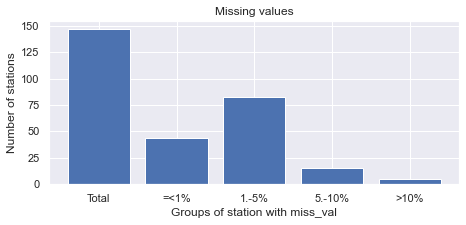

In [63]:
#Let's save into lists any stations name, that contain % of missing values:
# - less than 1%, 
# - between 1% and 5%, 
# - between 5% and 10% 
# - higher then 10%.
#Then we will choose the most consistent and delete all faulty.

per1_miss, per5_miss, per10_miss, per_miss = [], [], [], []

for ncol in name_stations:
    per_null = (data_2[ncol].isnull().sum()/data_2[ncol].shape[0])
    if per_null <= 0.01:
        per1_miss.append(ncol)
    elif 0.05 >= per_null > 0.01:
        per5_miss.append(ncol)
    elif 0.1 >= per_null > 0.05:
        per10_miss.append(ncol)
    else:
         per_miss.append(ncol)
     
names = ['Total','=<1%', '1.-5%', '5.-10%', '>10%']
values = [147, len(per1_miss),len(per5_miss),len(per10_miss),len(per_miss)]

plt.figure(figsize=(25, 3))
plt.subplot(131)
plt.title('Missing values')
plt.ylabel('Number of stations')
plt.xlabel('Groups of station with miss_val')
plt.bar(names, values)

In [64]:
#Let's remove from our name_stations list, cases, where missing value is more then 10%:
for ncol in per_miss:
    name_stations.remove(ncol)
print('Removed '+ str(len(per_miss)) + ' columns')

Removed 5 columns


In [65]:
no_miss_val = pd.DataFrame(data = data_2, columns = name_stations)

In [66]:
#Of course, we can handle with the missing values for all dateset in this simple way,
#but firstly, it is good practise to examine each specific column separtley. 
#After that, we should decide which filling method suits the best.
#For now we leave this part of code as a comment, because it may be helpfull soon.

# i = 0
# while i < len(name_stations):
#     name_col = name_stations[i]
#     median = no_miss_val[name_col].median()
#     no_miss_val[name_col] = no_miss_val[name_col].fillna(median)
#     i += 1   
# print('Missing value:', sum(no_miss_val.isnull().sum()))

In [67]:
#We need to transpose our dataset to be more suituable and usefull for the rest part of analysis.
#We set table columns one above another.
database = pd.DataFrame()

#First, grab an hours. 
for pakiet in range(len(name_stations)):
    time = pd.DataFrame(data_2['Time'])
    database = database.append(time)
database = database  

In [68]:
all_stat_codes = pd.DataFrame()

for num in range(len(name_stations)):
    code_stat = pd.DataFrame(data = list(map(lambda x: name_stations[num], range(data_2.shape[0]))))
    all_stat_codes = all_stat_codes.append(code_stat)

In [69]:
#Adding special number for each station. It might be helpful for binary encoding. Who knows.
number_stat_codes = pd.DataFrame()

for num in range(len(name_stations)):
    code_stat = pd.DataFrame(data = list(map(lambda x: num, range(data_2.shape[0]))))
    number_stat_codes = number_stat_codes.append(code_stat)

In [70]:
#Adding newly created stations codes to our database.
database['Num_Station_code'] = [x for x in number_stat_codes[0]]
database['Station_code'] = [x for x in all_stat_codes[0]]

In [71]:
#Let's grab all values from diffrent columns and order them into huge one.
all_values = pd.DataFrame()
for ncol in name_stations:
    all_values_col = [row for row in no_miss_val[ncol]]
    all_values = all_values.append(all_values_col)

In [72]:
database['Values'] = [x for x in all_values[0]]

In [73]:
columns_ordered = ['Time', 'Station_code', 'Num_Station_code', 'Values']
database = database[columns_ordered]

In [74]:
#And here we created our database 1. We need to 

In [89]:
#This function will be a function decorator, which will showing us, time of compution.

def performance(fn):
    def wrap_func(*args,**kwargs):
        t1 = time()
        result = fn(*args, **kwargs)
        t2 = time()
        print(f'Time compution: {t2-t1:,.2f} [s]')
        return result        
    return wrap_func

In [90]:
#All of the above we are able to encode as a one function. It helps us to keep code clear and manage with other xlsx files.
# @performance
def table(filename):    
    data = pd.read_excel(filename)
    columns_name = data.loc[0,:]
    columns_name = columns_name.replace('Kod stacji','Time')
    name_stations = list(columns_name)[1:]
    range_data = data.drop([x for x in range(5)], axis=0)
    range_data.rename(columns=columns_name, 
                     inplace=True)
    
#Some records in xlsx files contains floats saved as a strings. The loop below solves this issue, but unfortunately is very inefficient.
#That is way, conversion has been done via... Microsoft Excel, then files were saved and eventually loop was excluded.

#     for cols in columns_name[1:]:
#         for num in range_data[cols]:
#             if type(num) == str:
#                 range_data[cols][num] = float(num.replace(',','.'))
#             else:
#                 range_data[cols][num] = float(num)
    
    data_2 = range_data.copy()
    per1_miss, per5_miss, per10_miss, per_miss = [], [], [], []
    for ncol in name_stations:
        per_null = (data_2[ncol].isnull().sum()/data_2[ncol].shape[0])
        if per_null <= 0.01:
            per1_miss.append(ncol)
        elif 0.05 >= per_null > 0.01:
            per5_miss.append(ncol)
        elif 0.1 >= per_null > 0.05:
            per10_miss.append(ncol)
        else:
             per_miss.append(ncol)
    names = ['Total','=<1%', '1.-5%', '5.-10%', '>10%']
    
    for ncol in per_miss:
        name_stations.remove(ncol)
    no_miss_val = pd.DataFrame(data = data_2, columns = name_stations)
    i = 0

#We excluded this part of code, because we want to manage with missing values idividually on each station.
#     while i < len(name_stations):
#         name_col = name_stations[i]
#         median = no_miss_val[name_col].median()
#         no_miss_val[name_col] = no_miss_val[name_col].fillna(median)
#         i += 1
    database = pd.DataFrame()

    for pakiet in range(len(name_stations)):
        time = pd.DataFrame(data_2['Time'])
        database = database.append(time)
    database = database  
    all_stat_codes = pd.DataFrame()
    for num in range(len(name_stations)):
        code_stat = pd.DataFrame(data = list(map(lambda x: name_stations[num], range(data_2.shape[0]))))
        all_stat_codes = all_stat_codes.append(code_stat)
    number_stat_codes = pd.DataFrame()
    for num in range(len(name_stations)):
        code_stat = pd.DataFrame(data = list(map(lambda x: num, range(data_2.shape[0]))))
        number_stat_codes = number_stat_codes.append(code_stat)
    database['Num_Station_code'] = [x for x in number_stat_codes[0]]
    database['Station_code'] = [x for x in all_stat_codes[0]]
    all_values = pd.DataFrame()
    for ncol in name_stations:
        all_values_col = [row for row in no_miss_val[ncol]]
        all_values = all_values.append(all_values_col)
    database['Values'] = [x for x in all_values[0]]
    columns_ordered = ['Time', 'Station_code', 'Num_Station_code', 'Values']
    database = database[columns_ordered]
    return database

### Data preparation 2017

In [94]:
#That will take a while. Be patient.
NO2_data17 = table('2017_NO2_1g.xlsx')
PM25_data17 = table('2017_PM25_1g.xlsx')
PM10_data17 = table('2017_PM10_1g.xlsx')
SO2_data17 = table('2017_SO2_1g.xlsx')
O3_data17 = table('2017_O3_1g.xlsx')

### Data preparation 2018

In [87]:
#That will take a while...
NO2_data18 = table('2018_NO2_1g.xlsx')
PM25_data18 = table('2018_PM25_1g.xlsx')
PM10_data18 = table('2018_PM10_1g.xlsx')
SO2_data18 = table('2018_O3_1g.xlsx')
O3_data18 = table('2018_O3_1g.xlsx')

### Data preparation 2019 

In [88]:
#That will take a while...
NO2_data19 = database #table('2019_NO2_1g.xlsx')
PM25_data19 = table('2019_PM25_1g.xlsx')
PM10_data19 = table('2019_PM10_1g.xlsx')
SO2_data19 = table('2019_SO2_1g.xlsx')
O3_data19 = table('2019_O3_1g.xlsx')

In [93]:
#It is common knowledge that measured values of air pollution, strongly depends on location of each sations, while creating model we will focus on one of them only.
#Let's choose one station to make a model of emission. To do this, we need to find out, which station measures all interesting 
#parameters and has been worked since 2017 to 2019. Other words, we need to look a common space up for all belows sets.

common_space = (set(SO2_data17['Station_code']) &
 set(O3_data17['Station_code']) & 
 set(NO2_data17['Station_code']) & 
 set(PM25_data17['Station_code']) &
 set(PM10_data17['Station_code']) &

 set(SO2_data18['Station_code']) &
 set(O3_data18['Station_code']) &
 set(NO2_data18['Station_code']) &
 set(PM25_data18['Station_code']) & 
 set(PM10_data18['Station_code']) & 

 set(SO2_data19['Station_code']) & 
 set(O3_data19['Station_code']) & 
 set(NO2_data19['Station_code']) & 
 set(PM25_data19['Station_code']) & 
 set(PM10_data19['Station_code']))
common_space = list(common_space)

['MpKrakBujaka',
 'SlZlotPotLes',
 'DsWrocWybCon',
 'MzPlocMiReja',
 'PkMielBierna',
 'LdLodzGdansk',
 'LbLubObywate',
 'WmOlsPuszkin',
 'MzRadTochter',
 'SlKatoKossut',
 'DsJelGorOgin',
 'MzOtwoBrzozo']

In [98]:
#Now we can choose - totally arbitrarily - one of them, e.g. MzOtwoBrzozo. It seems ok.
chosen_station = common_space[11]
print(f'The chosen station is {chosen_station}')

The chosen station is MzOtwoBrzozo


In [100]:
#We need to make a connection with SQL Server in order to save our results. In further perspective, we might need that to
#manipulate data easier and quickier then using Python.

def export_df_to_MSSQL(dataset,server_name,
                       database_name,table_name):
    #dataset - dataframe to send to MS SQL Server
    #server_name, database_name - paramteres of MS SQL Serv.
    #table_name - name of created table in MS SQL Serv.
   
    table_name = "{}".format(table_name)#,today)
    
    dataset = dataset.reset_index()
    quoted = urllib.parse.quote_plus('Driver={SQL Server};'
                          f'Server={server_name};'
                          f'Database={database_name};'
                          'Trusted_Connection=yes;')
    
    engine = create_engine('mssql+pyodbc:///?odbc_connect={}'.format(quoted))
    dataset.to_sql(table_name, schema='dbo', con = engine)
    result = engine.execute(f'SELECT COUNT(*) FROM [dbo].[{table_name}]')
    return result.fetchall()[0]

# NO2 - nitorgen dioxide

In [69]:
#During the analysis, it turned out that each parameter requires diffrent approach.
#Hence, form now on we will be dealing with NO2 only. Down the road, we will be handling with other parameters too. 
#Let's combine data which comes from choosen station (MzOtwoBrzozo) for only one parameter throuhghout all 3 years.
#Thus, totally arbitrally again, we choose nitrogen dioxide for MzOtwoBrzozo.

NO2_stat = NO2_data17.loc[NO2_data17['Station_code'] == chosen_station]
NO2_stat = NO2_stat.append(NO2_data18.loc[NO2_data18['Station_code'] == chosen_station])
NO2_stat = NO2_stat.append(NO2_data19.loc[NO2_data19['Station_code'] == chosen_station])

In [71]:
#Now, we can store our datasets into safer place.
#The properities of SQL server you must define your own.

export_df_to_MSSQL(NO2_stat,'DESKTOP-8RKU8L8',
                       'GIOŚ','NO2_stat_with_missing')
#Alternatively:
# NO2_stat.to_csv('NO2_stat_with_missing.csv') 

(26280,)

In [3]:
#Import our data.
conn = pyodbc.connect('Driver={SQL Server};'
                      'Server=DESKTOP-8RKU8L8;'
                      'Database=GIOŚ;'
                      'Trusted_Connection=yes;')
cursor = conn.cursor()

#We have done some data featuring and manipulation (merge,join,convert,foreing keys etc.) 
#using T-SQL to create useful dataset. You can see the querry that contains an execution in attached file.
NO2_stat = pd.read_sql_query("""select * from NO2_stat_with_missing""",conn)

## Time-series preparation

In [4]:
#Let's delete unnecessary columns:
del NO2_stat['level_0'], NO2_stat['index'], NO2_stat['Num_Station_code']

In [5]:
#Let's transform Time column into datetype 
NO2_stat.describe()
#Here we can see that Python doesn't included in the summarise statistics,
#beacuse it treated values of this column as string type.  

,Values
count,25811.000000
mean,16.949676
std,13.537545
min,1.653438
25%,8.130000
50%,12.970000
75%,21.094704
max,120.790000


In [6]:
NO2_stat.Time.describe()
#It seems that Python recognized correctly the first and the last value.

count                   26280
unique                  26280
top       2017-09-24 19:00:00
freq                        1
first     2017-01-01 01:00:00
last      2020-01-01 00:00:00
Name: Time, dtype: object

### Convertion to datetype

In [7]:
#To be 100% sure, we convert data type after all.
NO2_stat.Time = pd.to_datetime(NO2_stat.Time, dayfirst = True)

In [8]:
NO2_stat.Time.describe()

count                   26280
unique                  26280
top       2017-09-24 19:00:00
freq                        1
first     2017-01-01 01:00:00
last      2020-01-01 00:00:00
Name: Time, dtype: object

### Setting date as an index

In [9]:
#Let's set Time column as a index of table to associated timeseries with 
#values.
NO2_stat.set_index('Time', inplace = True)

### Setting the frequency

In [10]:
NO2_stat = NO2_stat.asfreq('h')

### Handling with missing value

In [11]:
NO2_stat.isna().sum()

Station_code      0
Values          469
dtype: int64

In [12]:
print('Missing value ratio: ', (NO2_stat.isna().sum()[1]/NO2_stat.shape[0])*100,'%')

Missing value ratio:  1.784627092846271 %


In [203]:
#Let's display all missing values.
pd.set_option('display.max_rows', int(NO2_stat.isna().sum()[1]))
NO2_stat[NO2_stat.isna().any(axis=1)]

,Station_code,Values
Time,,
2017-01-28 15:00:00,MzOtwoBrzozo,NaN
2017-02-12 02:00:00,MzOtwoBrzozo,NaN
2017-03-09 10:00:00,MzOtwoBrzozo,NaN
2017-03-09 11:00:00,MzOtwoBrzozo,NaN
2017-03-10 21:00:00,MzOtwoBrzozo,NaN
2017-04-06 10:00:00,MzOtwoBrzozo,NaN
2017-04-06 11:00:00,MzOtwoBrzozo,NaN
2017-04-06 12:00:00,MzOtwoBrzozo,NaN
2017-04-06 13:00:00,MzOtwoBrzozo,NaN


<AxesSubplot:xlabel='Values', ylabel='Density'>

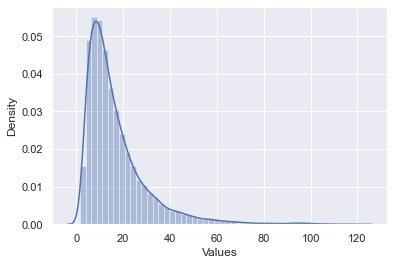

In [13]:
pd.set_option('display.max_rows', 10)

#Beacuse dataset comes from the real world, it contain a lot of missing values. 
#There are many reasons of that, e.g.: instrument calibration, breakdown station or turning off stations etc. 
#Exploring manually missing values, we have discovered that the missing values have periodicly character.
#It means that is not a good idea to use common methods such as Front Filling or Back Filling.
#Though, the mean method would be sufficient if the data oscilate around the mean.
#Let's check it out.

sns.distplot(NO2_stat['Values'])

#We can see the distributios of Values variable is rightskewness,
#so most of data is less then mean. Filling missing values by median should be
# more reasonbly but far from ideal solution.

In [14]:
#But before we do it, we should examine seasonality. Mayby there exsists some clearly viseable pattern.

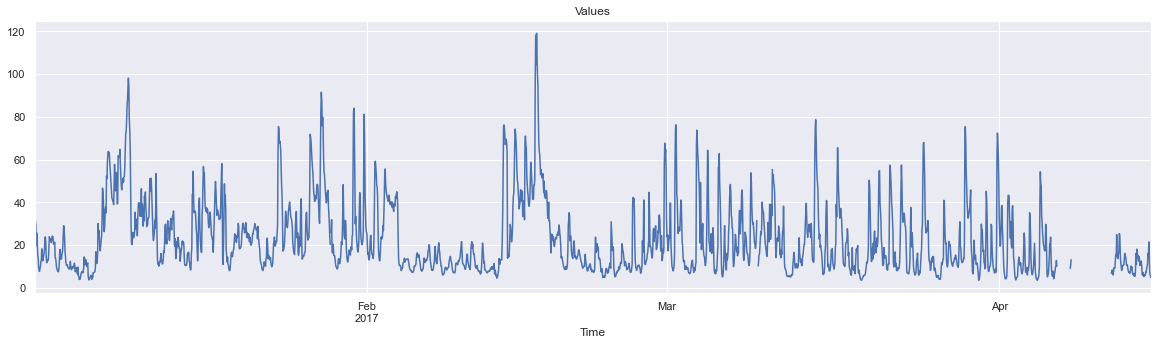

In [15]:
NO2_stat['Values'][:2500].plot(figsize=(20,5),title='Values')
plt.show()

In [16]:
#We can that the removing of 1% of data to make our dataset more consistent.
#All the more, the ratio between missing value and all data is quite small.

# q = NO2_stat['Values'].quantile(0.99)
# NO2_stat = NO2_stat[NO2_stat['Values']<q]
#That solution would eliminate missing values as well.
#We can also write some sofisticated function to fill missing valus according to
#datetime.

In [17]:
#Eventually, filling gaps by median will be our method but we must be aware the other solution like:
#linear interpolation, historical extrapolation, filling gaps using data collected by
#other stations in the nearst neighbourhood.
#These method colud give much more better accurate.
#There are not exist one appropriate method to deal with missing value in enviromental datasets.
#You can read about it here: https://www.researchgate.net/publication/313215274_A_REVIEW_MISSING_VALUE_IN_ENVIRONMENTAL_DATA_SETS
#Perheps, built a time-series model to filling missing values, could be raight approach? 
NO2_stat.Values = NO2_stat.Values.fillna(NO2_stat.Values.median())

### Splitting data

In [18]:
#Time-series is specific data type. As we do usually, we cannot shuffle the data before splitting it, 
#becasue the order has a crucial meaning in this case.
size = int(len(NO2_stat)*0.8)

In [19]:
df_train = NO2_stat.iloc[:size]
df_test = NO2_stat.iloc[size:]

### What type of time series are we dealing with?

##### All

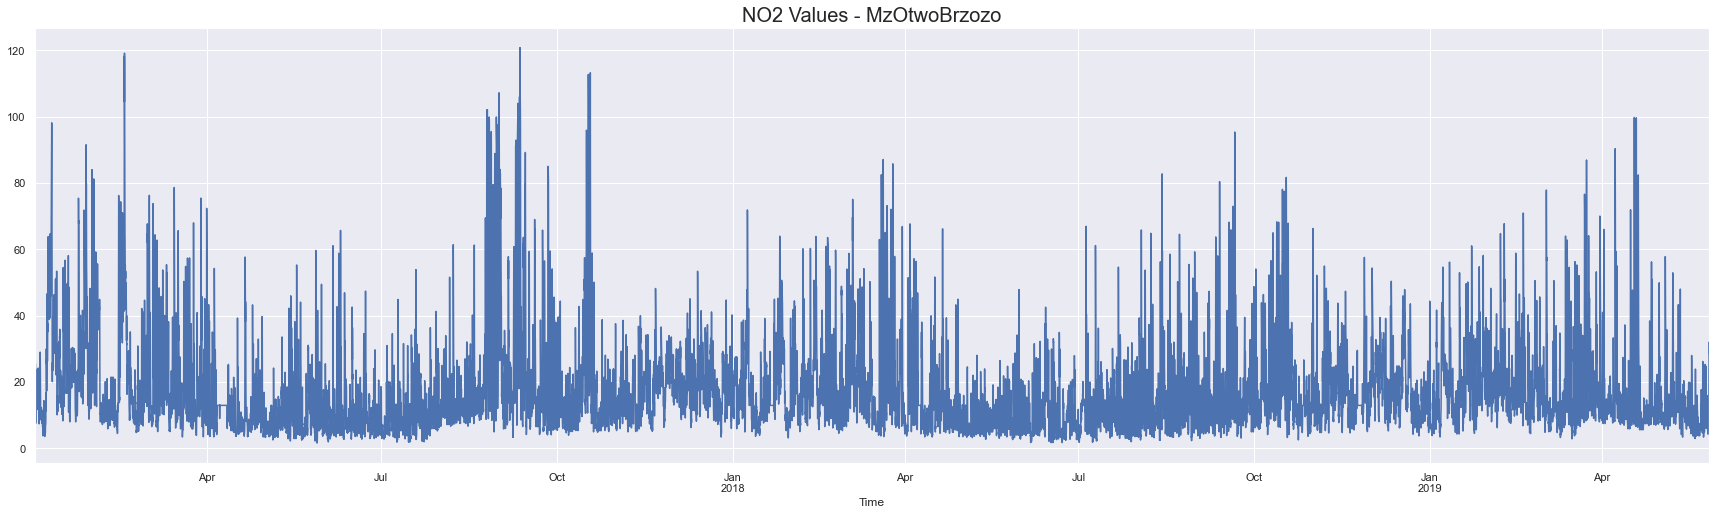

In [20]:
df_train.Values.plot(figsize=(30,8))
plt.title('NO2 Values - MzOtwoBrzozo', size = 20)
plt.show()
#Below we can see resemblance data to the white noise. 
#If we focus, we would be able to notice some pattern: the station registered the highest values Of NO2 each April and October.
#It is clearly visable since Oct 2017 to the end.

##### Yearly

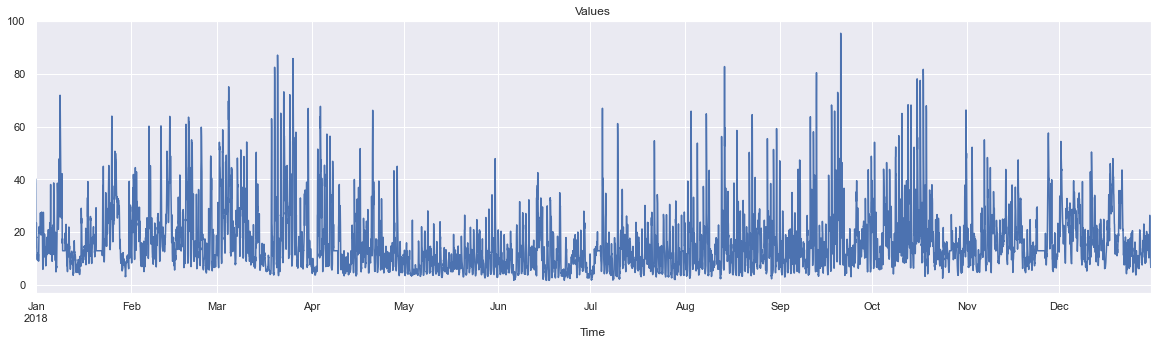

In [21]:
#Obviously Spring and Autumn contain max value.
NO2_stat['Values'][8750:17500].plot(figsize=(20,5),title='Values')
plt.show()

##### Monthly

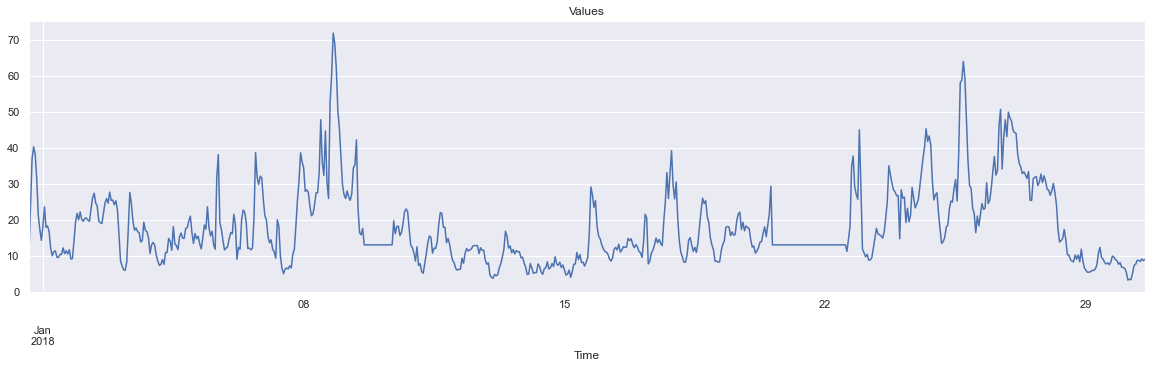

In [22]:
NO2_stat['Values'][8750:9470].plot(figsize=(20,5),title='Values')
plt.show()

##### Weekly

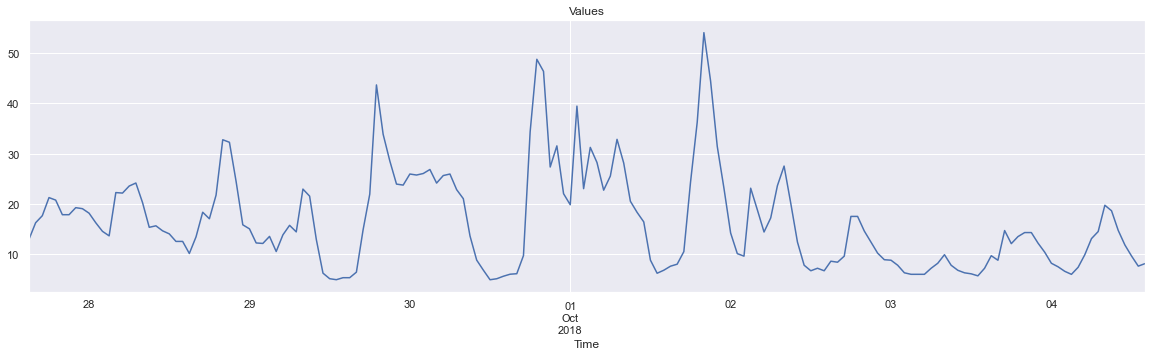

In [23]:
NO2_stat['Values'][15230:15398].plot(figsize=(20,5),title='Values')
plt.show()

##### Daily

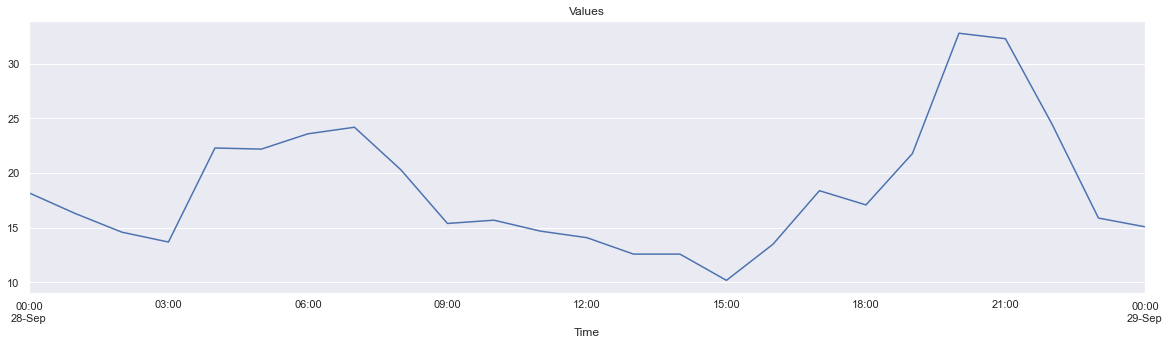

In [24]:
NO2_stat['Values'][15239:15264].plot(figsize=(20,5),title='Values')
plt.show()

### Checking ("weak-form"/covariance) stationarity or non-stationarity

In [25]:
#Stationarity means that the statistical properties of a a time series 
#(or rather the process generating it) do not change over time.

#Time-series stationarity implies that taking consecutive samples of data with the same size should have identical
#covariances regardless of the starting point, if it satisfies three key assumptions:
# - constant mean
# - constant variance
# - the data have to consistent covariance between periods at an identical distance.
#Typical stationarity data-series is white noise.

In [26]:
#To check it, we will use Dickey-Fuller test.
# H0 - non-stationary (1 lag autocorrelation coefficient is < 1)
# H1 - stationarity (1 lag autocorrelation coefficient is 1)
#If test-statistic is < critical value ==> the data comes from a stationary process.
sts.adfuller(df_train.Values)

(-10.381421918958713,
 2.1341016471755894e-18,
 46,
 20977,
 {'1%': -3.4306617748195767,
  '5%': -2.8616777938661917,
  '10%': -2.5668433438484324},
 125781.01685259727)

In [27]:
#t-statistic is < then each signicifant level: 1,5,10% thus time-series is stationary.
#We also see that p-vlue (associated with t-statistic) is very small (18 decimal places). It means propability of not reject H0,
#so we have really small chance to not reject null hipothesis (H0: non-stationarity).
#46 - represents num. of lags used in the regression when determining t-stat.
#It means there is autocorrelation going back 46 periods.
#20977 - num of observations used in the analysis
#125781. - estimates the maximized information criteria provided there is some apparent autocorrelation.
#The lower the values the easier it is to make predictions for the future to provide

### "Naive" seasonality

In [28]:
# There are several ways of testing for seasonality.
# One of them is decompose the sequence where we split up the time series into three effects:
# trend - the pattern consistent throughout the data.
# seasonal - all cyclical effects due to seasonality.
# residual - error of prediction or the difference between the actual data and the model we fit.
#We expect a linear relationship between these parts and observed time-series.

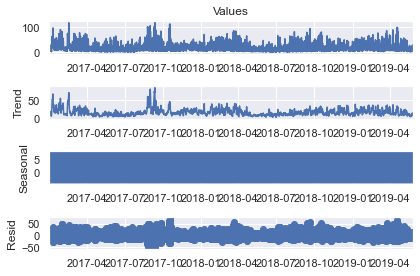

In [29]:
#First - observed values.
#Second - trend based on observed values.
#Third - seasonal 
#Fourth - the linear change results from constantly switching up and down.
#Therefore there is no concrete cyclical pattern determined by using naive decomposition.
#Fifth -  the errors of our model estimates. 
#It is very big. Supposedly, there are plenty variables which can affect on NO2 emission value.

#Let's start from additive approach - assumes that for any time period the observed value is the sum of the trend, seasonal, residual. 
s_dec_additive = seasonal_decompose(df_train['Values'], model = 'additive')
s_dec_additive.plot()
plt.show()

#If there is a seasonality, the trend should resmables Values.
#However, if the trend follows the observed closely, then the seasonal trend would be very low
#in magnitude compared to the trend, so it would have minimal effect.
#The cycles of observed values are not clear and spread out, then that gives evidence of non-seasonality.

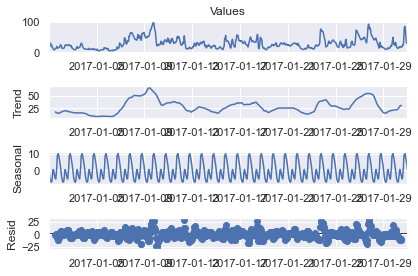

In [30]:
s_dec_additive = seasonal_decompose(df_train['Values'][:720], model = 'additive')
s_dec_additive.plot()
plt.show()
#For month:

In [31]:
#Overall the results of the additive decomposition suggest no seasonality in the data.

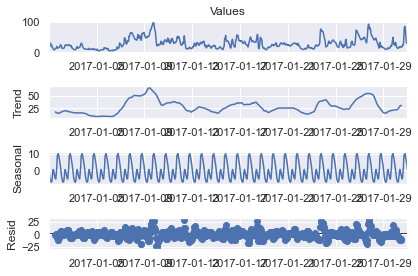

In [32]:
#Multiplicative approach - assumes that for any time period the observed value is the product of the trend, seasonal, residual. 
s_dec_multiplicative = seasonal_decompose(df_train['Values'], model = 'multiplicative')
s_dec_additive.plot()
plt.show()
#For all dataset:

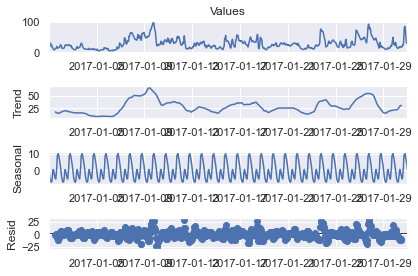

In [33]:
s_dec_multiplicative = seasonal_decompose(df_train['Values'][:720], model = 'multiplicative')
s_dec_additive.plot()
plt.show()
#For month:

In [227]:
#Overall, the results of the additive and multiplicative decompositions suggest no seasonality in the data.

### Correlation Between Past and Present Values

In [34]:
#Correlation measures the similarity in the change of values of two series ρ(x,y).
#We have only a single values x, so w need to autocorrelation (the correlation between a sequence and itself)
#It measures the level of resemblance between a sequence from several periods ago and actual data.
#Thus, we need to a calculate ACF (auto-corr func.).

##### ACF

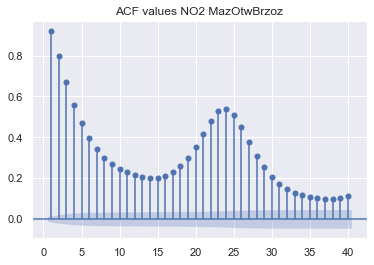

In [35]:
#40 - the last 40 periods before the current one.
#zero - we don't want to have on the graph current value because it spoil the scale (autocorr. for itsefl equals 1).
sgt.plot_acf(df_train.Values, lags = 40, zero = False)
plt.title('ACF values NO2 MazOtwBrzoz')
plt.show()


#The result below may be a little bit confusing. We have assumed no-seasonality in the dataset, based on 
#add-and-multiplicative decompozition analysis, but here we clearly see some kind of values oscillation.
#We can notice some decreseing trend as well.
#The slow decrease in the ACF as the lags increase is due to the trend
#We must be awere that when data are seasonal, 
#the autocorrelations will be larger for the seasonal lags 
#(at multiples of the seasonal frequency) than for other lags.
#https://otexts.com/fpp2/autocorrelation.html

#We can also see strong autocorrelation. 
#It is periodiclly changeably. It's very big for 1-2 hours ago. 

#It decreases very quickly after midnight. In the afternoon,
#changes are slight. Autocorr. increases from 16 and reaches the peak at midnight.
#In generall, autocorrelation barely diminishes as the lags increase with 24h periods-peak.
#Blue area - significance. The autocorrelation coefficient in higher lags is not sufficiently 
#greater to be significantly different from zero.
#The greater the distance in time the more unlikely it is that this auto correlation persists.

##### PACF

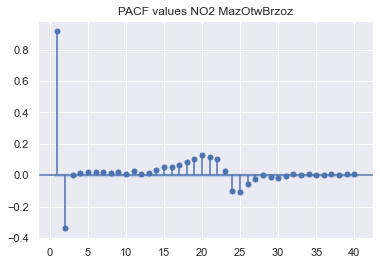

In [43]:
# The ACF measures the accumulated effects.
# Both measure the effect on past values on the current one.
# If we wish to determine only the direct relationship between 
# the time-series and its lagged version, we need to compute the PACF.
# Since we want to get the most efficient model, we only wish to include past lags which have a 
# direct significant effect on the present.
sgt.plot_pacf(df_train['Values'][:], lags = 40, zero = False, method = ('OLS') )
plt.title('PACF values NO2 MazOtwBrzoz')
plt.show()
#From 03:00 to 13:00 we observe value near to 0 
#and next day the process repeat (lags: 28-40).
#These coefficientas are not significiant, so our model shoud include 27 lags.
#Values 2 and after 23, are negative, because NO2 oscilate during a day.
#The values a day ago negatively affect the values today,
#but they are oveshadowed by first two values.

#Only the first two elements and form 14:00 to 03:00 (next day) exclusive of 00:00.
#Negative value like for 2-nd lag means that higher values two periods ago,
#result in lower values today and vice versa.
#On the graph below, we don't have a blue area which means the they significantly different from zero.

In [46]:
export_df_to_MSSQL(df_train,'DESKTOP-8RKU8L8',
                       'GIOŚ','NO2_MzOtwBrzozo_df_train')
export_df_to_MSSQL(df_test,'DESKTOP-8RKU8L8',
                       'GIOŚ','NO2_MzOtwBrzozo_df_test')

(5256,)

## Dataset 2, 3 last days

This dataset will contain NO2 emission values from last 3 days counting from just now. In the nearst future, we will be able to use it to make forecasts by using some of our models created on "Dataset 1". We will also use this dataset to visaulize emissions on the map via Tableau. So, what exectly are we going to do now?
- download current data via API GIOŚ's for last  3 days counting from now (that all what GIOŚ is provided)
http://powietrze.gios.gov.pl/pjp/content/api;
- convert jason files to the dataframe;
- merge all 3 tables (using Pandas and T-SQL);
- save the dataset

### Dwonloading Tab 1 - stacje pomarowe

In [38]:
def progres(step, limit, lag):
    #Becasue we do not want to be too agrssive for server
    #and downloading data may took some time,
    #this function shows us progres.  
    print("Requesting page {}/{}".format(step+1, limit))
    clear_output(wait = True)
    time.sleep(lag)

In [39]:
def clear_cols_names(cols_names):
    #This function removes dots from columns names and replaces them into _.
    #It helps us to work in MS SQL in the future.
    
    cols_names = [cols_names]
    
    colector = []
    for col in cols_names:
        new = []
        for sign in col:
            sign = sign.replace('.', '_')
            new.append(sign)
        colector.append(new)
    return colector[0]

In [40]:
url_api_1 = 'http://api.gios.gov.pl/pjp-api/rest/station/findAll'
response_1 = requests.get(url_api_1).json()
dataset_0 = pd.json_normalize(response_1)
cols_names_1 = clear_cols_names(dataset_0.columns)
dataset_1 = pd.DataFrame(data = dataset_0)
dataset_1.columns = cols_names_1

### Downloading Tab 2 - stanowiska pomiarowe

In [41]:
first_id = dataset_1['id'][0]
url_api_2 = f'http://api.gios.gov.pl/pjp-api/rest/station/sensors/{first_id}'
response_2 = requests.get(url_api_2).json()
dataset_2 = pd.DataFrame(pd.json_normalize(response_2))

#Total pages is total number of measuring stations.
total_pages = dataset_1.shape[0]
for page in range(total_pages):
    
    progres(page, total_pages, 0.2)   
    
    id_station = dataset_1['id']
    url_api_2 = f'http://api.gios.gov.pl/pjp-api/rest/station/sensors/{id_station[page]}'
    response_2 = requests.get(url_api_2).json()
    df_one_page = pd.json_normalize(response_2)
    dataset_2 = dataset_2.append(df_one_page)
    
cols_names_2 = clear_cols_names(pd.json_normalize(response_2).keys())
dataset_2.columns = cols_names_2

KeyboardInterrupt: 

### Dwonloading Tab 3 - dane pomiarowe

In [42]:
# Let's create empty dataframe that will store our data.
first_id = int(dataset_2.reset_index()['id'][0])
url_api_3 = f'http://api.gios.gov.pl/pjp-api/rest/data/getData/{first_id}'
response_3 = requests.get(url_api_3).json()
# parameter = response_3['key']
value = response_3['values']
dataset_3 = pd.json_normalize(value)
# dataset_3['parameter'] = parameter
cols_names_3 = clear_cols_names(dataset_3.columns)
dataset_3 = pd.DataFrame(columns=cols_names_3)

id_para = [int(x) for x in dataset_2['id']]
for page in range(dataset_2.shape[0]):
    
    print("Requesting page {}/{}".format(page+1, len(id_para)))
    clear_output(wait = True)
    time.sleep(0.20) 
    
    progres(page, len(id_para), 0.15)
    
    url_api_3 = f'http://api.gios.gov.pl/pjp-api/rest/data/getData/{id_para[page]}'
    response_3 = requests.get(url_api_3).json()
    parametr = response_3['key']
    value = response_3['values']
    df_one_page = pd.json_normalize(value)
    df_one_page['parametr'] = parametr
    df_one_page['Id_para'] = id_para[page]
    dataset_3 = dataset_3.append(df_one_page)

cols_names_3 = clear_cols_names(dataset_3.columns)
dataset_3.columns = cols_names_3

KeyboardInterrupt: 

In [ ]:
export_df_to_MSSQL(dataset_1,'DESKTOP-8RKU8L8',
                   'GIOŚ','stacje_pomiarowe')
export_df_to_MSSQL(dataset_2,'DESKTOP-8RKU8L8',
                   'GIOŚ','stanowiska_pomiarowe')
export_df_to_MSSQL(dataset_3,'DESKTOP-8RKU8L8',
                   'GIOŚ','dane pomiarowe')

### Time-series preparation

In [47]:
conn = pyodbc.connect('Driver={SQL Server};'
                      'Server=DESKTOP-8RKU8L8;'
                      'Database=GIOŚ;'
                      'Trusted_Connection=yes;')
cursor = conn.cursor()
#Check the querry to understand code below.
NO2_last_value = pd.read_sql_query("""exec LastValue 'Ot%', 'NO2' """,conn)

In [48]:
#This table is prepared not for only creating a model but visualize current value of NO2 using Talbelau as well.
#So we need to do quick data engineering again.
NO2_last_value

,id,Latitude,Longitude,StationName,Voivodeship,Time,Hour_,Day_,PhysicochemicalFormula,Values,Unit,IndexQuality
0,16048,52.115725,21.237297,Otwock-Brzozowa ...,MAZOWIECKIE,2020-10-06 01:00:00,01:00,6,NO2,5.89,µg/m3,Very good
1,16048,52.115725,21.237297,Otwock-Brzozowa ...,MAZOWIECKIE,2020-10-06 02:00:00,02:00,6,NO2,5.68,µg/m3,Very good
2,16048,52.115725,21.237297,Otwock-Brzozowa ...,MAZOWIECKIE,2020-10-06 03:00:00,03:00,6,NO2,6.27,µg/m3,Very good
3,16048,52.115725,21.237297,Otwock-Brzozowa ...,MAZOWIECKIE,2020-10-06 04:00:00,04:00,6,NO2,7.69,µg/m3,Very good
4,16048,52.115725,21.237297,Otwock-Brzozowa ...,MAZOWIECKIE,2020-10-06 05:00:00,05:00,6,NO2,8.57,µg/m3,Very good
...,...,...,...,...,...,...,...,...,...,...,...,...
59,16048,52.115725,21.237297,Otwock-Brzozowa ...,MAZOWIECKIE,2020-10-08 13:00:00,13:00,8,NO2,15.69,µg/m3,Very good
60,16048,52.115725,21.237297,Otwock-Brzozowa ...,MAZOWIECKIE,2020-10-08 14:00:00,14:00,8,NO2,13.65,µg/m3,Very good
61,16048,52.115725,21.237297,Otwock-Brzozowa ...,MAZOWIECKIE,2020-10-08 15:00:00,15:00,8,NO2,11.27,µg/m3,Very good
62,16048,52.115725,21.237297,Otwock-Brzozowa ...,MAZOWIECKIE,2020-10-08 16:00:00,16:00,8,NO2,10.99,µg/m3,Very good


In [49]:
NO2_api = NO2_last_value.copy()

In [50]:
del NO2_api['Latitude'], NO2_api['Longitude'], NO2_api['StationName'], NO2_api['Voivodeship'], NO2_api['Hour_'], NO2_api['Day_'], NO2_api['PhysicochemicalFormula'], NO2_api['Unit'], NO2_api['IndexQuality']

In [51]:
NO2_api.Time.describe()

count                      64
unique                     64
top       2020-10-07 12:00:00
freq                        1
first     2020-10-06 01:00:00
last      2020-10-08 17:00:00
Name: Time, dtype: object

In [52]:
NO2_api.Time = pd.to_datetime(NO2_api.Time, dayfirst = True)

In [53]:
NO2_api.set_index('Time', inplace = True)

In [54]:
NO2_api = NO2_api.asfreq('h')

In [55]:
NO2_api.isna().sum()

id        1
Values    1
dtype: int64

In [56]:
NO2_api.Values = NO2_api.Values.fillna(NO2_api.Values.median())

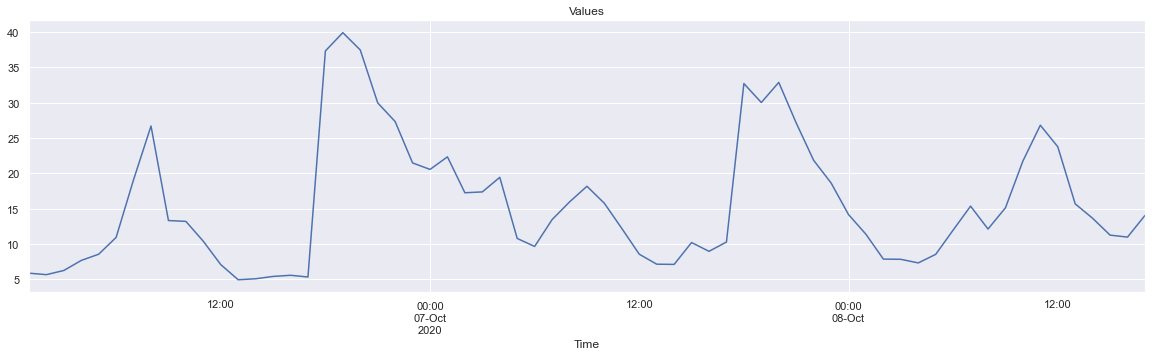

In [57]:
NO2_api['Values'].plot(figsize=(20,5),title='Values')
plt.show()

In [65]:
export_df_to_MSSQL(NO2_api,'DESKTOP-8RKU8L8',
                   'GIOŚ','NO2_MzOtwBrzozo_df_api')

(64,)

# MODEL 1
## AR - autoregressive

### yearly (2017-19)

##### The simple AR(1) model

In [3]:
conn = pyodbc.connect('Driver={SQL Server};'
                      'Server=DESKTOP-8RKU8L8;'
                      'Database=GIOŚ;'
                      'Trusted_Connection=yes;')
cursor = conn.cursor()
#Check the querry to understand code below.
df_train = pd.read_sql_query("""select * from NO2_MzOtwBrzozo_df_train""",conn)
df_train.set_index('Time', inplace = True)
del df_train['index'], df_train['Station_code']

In [4]:
# For starters the new coefficients for the more complex model 
# need to be significantly different from 0. If are not, the have no predictive powers.
# We want our model as simple as possible, however complex model gives better results.

#AR models suit well to stationarity process.
#Because it is simple autoregressive model we set 
#an order: 1 - num of past values incorporate into model,
# 0 - any residual values into consideration 
model_ar = ARMA(df_train.Values, order =[1,0])

In [5]:
results_ar = model_ar.fit()

In [6]:
results_ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                 Values   No. Observations:                21024
Model:                     ARMA(1, 0)   Log Likelihood              -65432.566
Method:                       css-mle   S.D. of innovations              5.437
Date:                Sun, 08 Nov 2020   AIC                         130871.132
Time:                        10:51:22   BIC                         130894.993
Sample:                    01-01-2017   HQIC                        130878.920
                         - 05-27-2019                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           17.3204      0.477     36.305      0.000      16.385      18.255
ar.L1.Values     0.9214      0.003    343.975      0.000       0.916       0.927
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0853           +0.0000j            1.0853            0.0000
-----------------------------------------------------------------------------
"""

##### Higher-Lag AR Models

In [7]:
model_ar_2 = ARMA(df_train.Values, order =[2,0])
results_ar_2 = model_ar_2.fit()
results_ar_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                 Values   No. Observations:                21024
Model:                     ARMA(2, 0)   Log Likelihood              -64142.866
Method:                       css-mle   S.D. of innovations              5.114
Date:                Sun, 08 Nov 2020   AIC                         128293.732
Time:                        10:51:24   BIC                         128325.546
Sample:                    01-01-2017   HQIC                        128304.115
                         - 05-27-2019                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           17.3121      0.335     51.679      0.000      16.656      17.969
ar.L1.Values     1.2345      0.006    190.338      0.000       1.222       1.247
ar.L2.Values    -0.3398      0.006    -52.387      0.000      -0.353      -0.327
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2190           +0.0000j            1.2190            0.0000
AR.2            2.4141           +0.0000j            2.4141            0.0000
-----------------------------------------------------------------------------
"""

In [8]:
model_ar_3 = ARMA(df_train.Values, order =[3,0])
results_ar_3 = model_ar_3.fit()
results_ar_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                 Values   No. Observations:                21024
Model:                     ARMA(3, 0)   Log Likelihood              -64142.863
Method:                       css-mle   S.D. of innovations              5.114
Date:                Sun, 08 Nov 2020   AIC                         128295.726
Time:                        10:51:26   BIC                         128335.493
Sample:                    01-01-2017   HQIC                        128308.706
                         - 05-27-2019                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           17.3120      0.335     51.652      0.000      16.655      17.969
ar.L1.Values     1.2347      0.007    179.035      0.000       1.221       1.248
ar.L2.Values    -0.3404      0.011    -31.806      0.000      -0.361      -0.319
ar.L3.Values     0.0005      0.007      0.076      0.940      -0.013       0.014
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2185           +0.0000j            1.2185            0.0000
AR.2            2.4241           +0.0000j            2.4241            0.0000
AR.3          648.9493           +0.0000j          648.9493            0.0000
-----------------------------------------------------------------------------
"""

In [9]:
model_ar_4 = ARMA(df_train.Values, order =[4,0])
results_ar_4 = model_ar_4.fit()
results_ar_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                 Values   No. Observations:                21024
Model:                     ARMA(4, 0)   Log Likelihood              -64141.632
Method:                       css-mle   S.D. of innovations              5.114
Date:                Sun, 08 Nov 2020   AIC                         128295.264
Time:                        10:51:28   BIC                         128342.984
Sample:                    01-01-2017   HQIC                        128310.839
                         - 05-27-2019                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           17.3121      0.339     51.097      0.000      16.648      17.976
ar.L1.Values     1.2347      0.007    179.045      0.000       1.221       1.248
ar.L2.Values    -0.3368      0.011    -30.733      0.000      -0.358      -0.315
ar.L3.Values    -0.0128      0.011     -1.172      0.241      -0.034       0.009
ar.L4.Values     0.0108      0.007      1.569      0.117      -0.003       0.024
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2068           -0.0000j            1.2068           -0.0000
AR.2           -6.5506           -0.0000j            6.5506           -0.5000
AR.3            3.2652           -1.0131j            3.4187           -0.0479
AR.4            3.2652           +1.0131j            3.4187            0.0479
-----------------------------------------------------------------------------
"""

In [10]:
model_ar_7 = ARMA(df_train.Values, order =[7,0])
results_ar_7 = model_ar_7.fit()
results_ar_7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                 Values   No. Observations:                21024
Model:                     ARMA(7, 0)   Log Likelihood              -64127.359
Method:                       css-mle   S.D. of innovations              5.110
Date:                Sun, 08 Nov 2020   AIC                         128272.719
Time:                        10:51:31   BIC                         128344.300
Sample:                    01-01-2017   HQIC                        128296.081
                         - 05-27-2019                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           17.3126      0.361     47.944      0.000      16.605      18.020
ar.L1.Values     1.2336      0.007    178.916      0.000       1.220       1.247
ar.L2.Values    -0.3361      0.011    -30.689      0.000      -0.358      -0.315
ar.L3.Values    -0.0053      0.011     -0.476      0.634      -0.027       0.017
ar.L4.Values    -0.0086      0.011     -0.770      0.442      -0.031       0.013
ar.L5.Values     0.0035      0.011      0.316      0.752      -0.018       0.025
ar.L6.Values    -0.0066      0.011     -0.604      0.546      -0.028       0.015
ar.L7.Values     0.0219      0.007      3.180      0.001       0.008       0.035
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1483           -0.0000j            1.1483           -0.0000
AR.2            1.2997           -0.7826j            1.5171           -0.0863
AR.3            1.2997           +0.7826j            1.5171            0.0863
AR.4            0.0749           -1.9644j            1.9658           -0.2439
AR.5            0.0749           +1.9644j            1.9658            0.2439
AR.6           -1.7981           -1.1099j            2.1130           -0.4120
AR.7           -1.7981           +1.1099j            2.1130            0.4120
-----------------------------------------------------------------------------
"""

##### LLR Test & Comparing Higher-Lag Models

In [45]:
# If we're comparing two models and we want to choose the better fit, 
# then we choose the one with higher 
# LLRT and lower information criteria (AIC/BIC)

# To determine whether the predictions are significantly better,
# we introduce a statistical test called the log likelihood ratio 
# test (LLRT). LLRT can only be applied to models with different degrees of freedom. 
# Thus, when comparing several models with the same total number of required lags, 
# we need to compare the information criteria of each one


def LLR_test(mod_1,mod_2,DF=1):
    L1 = mod_1.fit().llf
    L2 = mod_2.fit().llf
    LR = (2*(L2-L1))
    p = chi2.sf(LR,DF).round(3)
    return p

In [12]:
#We see that the difference in log likelihood is unsignificant in the second and third example.
#The rest: highly significant.
#We are going to choose 7 lags. It means that including 7 lags has a bigger predictive power
#even with several nonsignificant coefficients.
##First 3 lags have high significance. This remark is confirmed in this article: 
#http://www.pzits.not.pl/docs/ksiazki/Pol_2010/Hoffman%20153-162.pdf
#If we select 27 lags looking on PACF, the PC machine would... slow down and process never complete.

print('LLR tests p-values:')
print(LLR_test(model_ar, model_ar_2))
print(LLR_test(model_ar_2, model_ar_3))
print(LLR_test(model_ar_3, model_ar_4))
print(LLR_test(model_ar_4, model_ar_7))

LLR tests p-values:
0.0
0.94
0.117
0.0


### Normalizing Values 

In [13]:
# When we normalize a set of values we basically map every value of the sample space
# to the % of the first value of the set.
# By normalizing 2 time series we can compare how well they perform relative to one another.
# In general by normalizing 2 time series we can compare how well they perform relative to one another.

# We need a benchmark. We simply go with the value for the first period.
benchmark = df_train.Values.iloc[0]

In [14]:
#Dividing by benchmark all values and multiply by 100.
df_train['norm'] = df_train.Values.div(benchmark).mul(100)

In [15]:
#P-value is tramandeius low so the new dataseries is stationarity.
sts.adfuller(df_train.norm)

(-10.381421918958733,
 2.1341016471753433e-18,
 46,
 20977,
 {'1%': -3.4306617748195767,
  '5%': -2.8616777938661917,
  '10%': -2.5668433438484324},
 172676.99281719048)

In [16]:
model_norm_ar_7 = ARMA(df_train.norm, order =[7,0])
results_norm_ar_7 = model_norm_ar_7.fit()
results_norm_ar_7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                   norm   No. Observations:                21024
Model:                     ARMA(7, 0)   Log Likelihood              -87627.884
Method:                       css-mle   S.D. of innovations             15.627
Date:                Sun, 08 Nov 2020   AIC                         175273.768
Time:                        10:58:04   BIC                         175345.348
Sample:                    01-01-2017   HQIC                        175297.130
                         - 05-27-2019                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         52.9455      1.104     47.946      0.000      50.781      55.110
ar.L1.norm     1.2336      0.007    178.916      0.000       1.220       1.247
ar.L2.norm    -0.3361      0.011    -30.689      0.000      -0.358      -0.315
ar.L3.norm    -0.0053      0.011     -0.476      0.634      -0.027       0.017
ar.L4.norm    -0.0086      0.011     -0.769      0.442      -0.031       0.013
ar.L5.norm     0.0035      0.011      0.316      0.752      -0.018       0.025
ar.L6.norm    -0.0066      0.011     -0.603      0.546      -0.028       0.015
ar.L7.norm     0.0219      0.007      3.180      0.001       0.008       0.035
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1483           -0.0000j            1.1483           -0.0000
AR.2            1.2997           -0.7826j            1.5171           -0.0863
AR.3            1.2997           +0.7826j            1.5171            0.0863
AR.4            0.0749           -1.9644j            1.9658           -0.2439
AR.5            0.0749           +1.9644j            1.9658            0.2439
AR.6           -1.7981           -1.1099j            2.1131           -0.4120
AR.7           -1.7981           +1.1099j            2.1131            0.4120
-----------------------------------------------------------------------------
"""

In [20]:
#While compering model before normalization and after that,
#we can assume that normalizing does not have any effect on model selection
#(the same coefficients except of constant C).

### Analysing the residuals

In [21]:
# Ideally, the residuals should follow a random walk process so they should be stationary.

In [23]:
df_train['res_values'] = results_norm_ar_7.resid

In [24]:
# The mean is close to zero which suggests that 
# on average our model performs well.
df_train.res_values.mean()

-0.0009552401647171832

In [25]:
#Variance indicates the residuals are concentrated 
#around the mean of 0.
df_train.res_values.var()

244.30772620712384

In [26]:
#p-value is near to 0 and t-stat<0,01. It is stationary.
sts.adfuller(df_train.res_values)

(-15.245380083711307,
 5.095165446596477e-28,
 46,
 20977,
 {'1%': -3.4306617748195767,
  '5%': -2.8616777938661917,
  '10%': -2.5668433438484324},
 172879.07736626003)

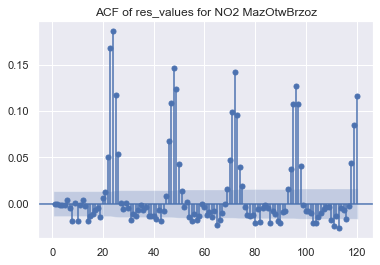

In [35]:
sgt.plot_acf(df_train.res_values, lags = 120, zero = False)
plt.title('ACF of res_values for NO2 MazOtwBrzoz')
plt.show()
#The majority of coefficients fall within the blue region.
#This suggests they're not significantly different from zero.
#Once more, we clearly see seasonanlity.

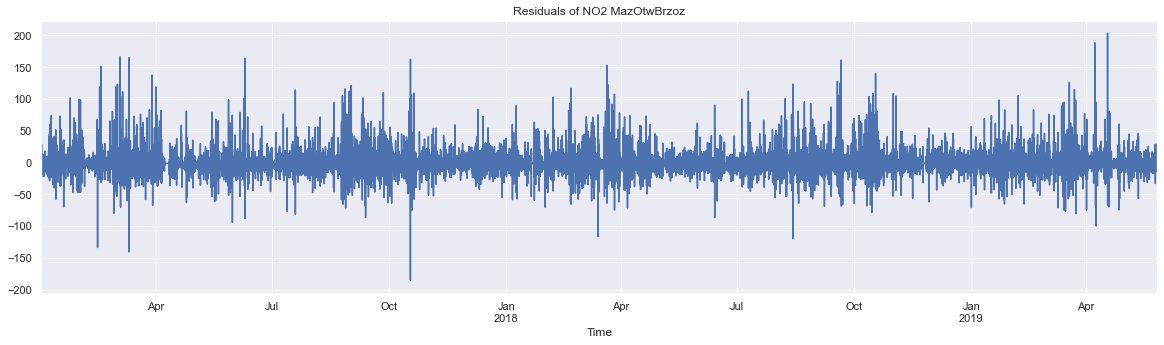

In [28]:
#We must plot the values of the residuals to see if they resemble what we are used to expecting from white noise data.
df_train.res_values[1:].plot(figsize=(20,5))
plt.title('Residuals of NO2 MazOtwBrzoz')
plt.show()
#We see some pattern on the graph below. Between each periods (length ~7 months) ocurrs a white noise. 
#If the residuals are none random (not white-noise) then there is a pattern that needs to be accounted for.
#So we need to fix it. We need to include... seasonality.

In [29]:
#DF test shows that the set is stationary (p-vlue ~0).
#We expected white noise and white noise is not the same as stationarity.
sts.adfuller(df_train.res_values[1:])

(-15.244714486880262,
 5.105412356153443e-28,
 46,
 20976,
 {'1%': -3.430661789684803,
  '5%': -2.8616778004357712,
  '10%': -2.566843347345297},
 172871.35096087528)

In [254]:
#We have no doubt that we need to include to our model seasonality.
#Thus, how do we inlucde to our model non consecutive lags?
#In other words, how to include that seasonality?
#We must to encorporate SARIMA model or SARIMAX.
#To do it, firstly, we must to introduce the moving average model.

# MODEL 2
## MA - moving average

In [36]:
conn = pyodbc.connect('Driver={SQL Server};'
                      'Server=DESKTOP-8RKU8L8;'
                      'Database=GIOŚ;'
                      'Trusted_Connection=yes;')
cursor = conn.cursor()
#Check the querry to understand code below.
df_train2 = pd.read_sql_query("""select * from NO2_MzOtwBrzozo_df_train""",conn)
df_train2.set_index('Time', inplace = True)
del df_train2['index'], df_train2['Station_code']

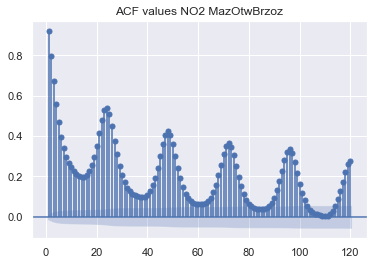

In [37]:
#Let's plot once again ACF:
sgt.plot_acf(df_train2.Values, lags = 120, zero = False)
plt.title('ACF values NO2 MazOtwBrzoz')
plt.show()
#As we see below on the graph, all of the coeff. are very significant.
#This leads us to believe that we'd have to use an infinite MA model to fit this data.
#Since no such thing exists, it seems that no moving average model would be a good estimate NO2 values.
#The D-F test says we are dealing with stationary data but all coeff. below are significant as coeff. in the stationary data.
#We are ready to conldude that MA model, in this case, is not good choice.
#This issue seems be problematic. We know that random-walk is non-stationary data and the MA model deals with it pretty well.
#That is way it must exists some compromise (AR+MA model).
#However, before we try ARMA model, we can veryfi ACF results building MA model.

#### MA model

In [38]:
#First value - AR components 0 
#second - MA ones 1 
model_ma_1 = ARMA(df_train2.Values,order=[0,1])
results_model_ma_1 = model_ma_1.fit()
results_model_ma_1.summary()
#The coefficient for the 1 lag ago residual is significant 
#at least the 1 percent level.

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                 Values   No. Observations:                21024
Model:                     ARMA(0, 1)   Log Likelihood              -74867.658
Method:                       css-mle   S.D. of innovations              8.517
Date:                Sun, 08 Nov 2020   AIC                         149741.316
Time:                        11:22:38   BIC                         149765.177
Sample:                    01-01-2017   HQIC                        149749.104
                         - 05-27-2019                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           17.3061      0.107    161.014      0.000      17.095      17.517
ma.L1.Values     0.8298      0.003    290.852      0.000       0.824       0.835
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -1.2051           +0.0000j            1.2051            0.5000
-----------------------------------------------------------------------------
"""

In [39]:
#If we want to > 1 lags to include, we need to put into the model at least 4.
model_ma_4 = ARMA(df_train2.Values,order=(0,4))
results_model_ma_4 = model_ma_4.fit()
results_model_ma_4.summary()
#The table below confirms our conclusion from ACF plot above.
#All coeff are significant.

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                 Values   No. Observations:                21024
Model:                     ARMA(0, 4)   Log Likelihood              -65717.447
Method:                       css-mle   S.D. of innovations              5.512
Date:                Sun, 08 Nov 2020   AIC                         131446.894
Time:                        11:22:41   BIC                         131494.614
Sample:                    01-01-2017   HQIC                        131462.469
                         - 05-27-2019                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           17.3072      0.167    103.596      0.000      16.980      17.635
ma.L1.Values     1.2475      0.007    178.958      0.000       1.234       1.261
ma.L2.Values     1.0979      0.009    120.666      0.000       1.080       1.116
ma.L3.Values     0.7342      0.008     95.913      0.000       0.719       0.749
ma.L4.Values     0.3159      0.006     52.203      0.000       0.304       0.328
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            0.0183           -1.3043j            1.3044           -0.2478
MA.2            0.0183           +1.3043j            1.3044            0.2478
MA.3           -1.1805           -0.6833j            1.3640           -0.4165
MA.4           -1.1805           +0.6833j            1.3640            0.4165
-----------------------------------------------------------------------------
"""

In [40]:
#The output is a p value of 0, which means the MA4 makes significantly better results.
print('\nnLLR test p-value = ' + str(LLR_test(model_ma_1,model_ma_4)))


nLLR test p-value = 0.0


In [44]:
#It will take a while depending on your CPU speed performance.
model_ma_10 = ARMA(df_train2.Values,order=(0,10))
results_model_ma_10 = model_ma_10.fit()
results_model_ma_10.summary()
#All 15 coeff. are significant. This leads us to conclusion that
#the more coeff. we include, the better improve predictions we should obtain.
#But, eventually, how many lags should we include? It's getting inefficient.

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                 Values   No. Observations:                21024
Model:                    ARMA(0, 10)   Log Likelihood              -64233.751
Method:                       css-mle   S.D. of innovations              5.136
Date:                Sun, 08 Nov 2020   AIC                         128491.502
Time:                        11:26:23   BIC                         128586.943
Sample:                    01-01-2017   HQIC                        128522.652
                         - 05-27-2019                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            17.3096      0.265     65.284      0.000      16.790      17.829
ma.L1.Values      1.2391      0.007    179.705      0.000       1.226       1.253
ma.L2.Values      1.1939      0.011    109.459      0.000       1.173       1.215
ma.L3.Values      1.0487      0.013     78.214      0.000       1.022       1.075
ma.L4.Values      0.8693      0.015     59.241      0.000       0.841       0.898
ma.L5.Values      0.6943      0.015     46.426      0.000       0.665       0.724
ma.L6.Values      0.5315      0.015     36.010      0.000       0.503       0.560
ma.L7.Values      0.3969      0.014     27.534      0.000       0.369       0.425
ma.L8.Values      0.2699      0.013     20.383      0.000       0.244       0.296
ma.L9.Values      0.1721      0.011     15.842      0.000       0.151       0.193
ma.L10.Values     0.0709      0.007     10.054      0.000       0.057       0.085
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
MA.1             0.9743           -0.8227j            1.2752           -0.1116
MA.2             0.9743           +0.8227j            1.2752            0.1116
MA.3             0.3834           -1.2244j            1.2830           -0.2017
MA.4             0.3834           +1.2244j            1.2830            0.2017
MA.5            -0.3145           -1.2552j            1.2940           -0.2891
MA.6            -0.3145           +1.2552j            1.2940            0.2891
MA.7            -0.9325           -0.9106j            1.3034           -0.3769
MA.8            -0.9325           +0.9106j            1.3034            0.3769
MA.9            -1.3248           -0.3134j            1.3613           -0.4630
MA.10           -1.3248           +0.3134j            1.3613            0.4630
------------------------------------------------------------------------------
"""

In [45]:
print('\nnLLR test p-value = ' + str(LLR_test(model_ma_4,model_ma_10)))


nLLR test p-value = 0.0


#### Residuals

In [46]:
df_train2['res_ma_10'] = results_model_ma_10.resid[1:]

In [47]:
print('Mean =',round(df_train2.res_ma_10.mean(),3),
'Variance =',round(df_train2.res_ma_10.var(),3))

Mean = -0.001 Variance = 26.379


In [48]:
#Our data is stationary such as white noise. WN implies normality. 
#In order to use 68,95,99.7 rule (3 sigma rule), we need to compute a std.
print('std = ' + str(math.sqrt(df_train2.res_ma_10.var())))
#This dictates what part of the data is spread within 1 2 and 3 sigma from a mean.
#We expect that the most residuals will be between <-3*std,3*std>
#This means that worst case scenario we could be up to 30.66% off 
#when predicting the values of NO2 emission.

std = 5.136061360695958


Text(0.5, 1.0, 'MA model - Residuals of values NO2 MzOtwBrzozo')

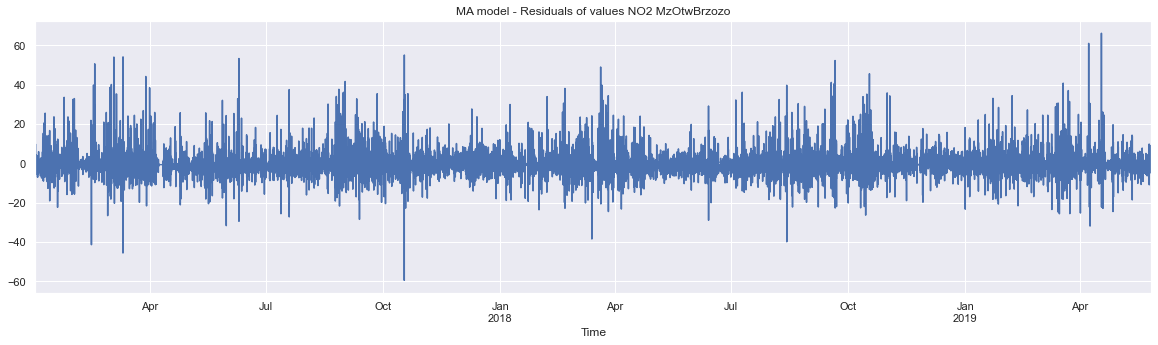

In [49]:
#But before we agree that this model is... insufficient, firstly, let's  examine its graph.
df_train2.res_ma_10[1:].plot(figsize=(20,5))
plt.title('MA model - Residuals of values NO2 MzOtwBrzozo')
#The residuals are rather random. Rather.

In [50]:
#DF test shows that the set is stationary (p-vlue ~0).
#We expected white noise and white noise is not the same as stationarity.
sts.adfuller(df_train2.res_ma_10[1:])

(-13.991949594658443,
 4.001830598302741e-26,
 46,
 20976,
 {'1%': -3.430661789684803,
  '5%': -2.8616778004357712,
  '10%': -2.566843347345297},
 125987.30326699716)

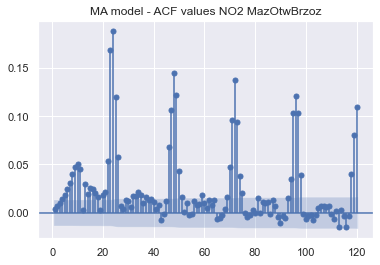

In [54]:
#A white noise process, produces completely random data. 
#And all the ACF coefficients should not be significantly different from 0.
sgt.plot_acf(df_train2.res_ma_10[2:], lags = 120, zero = False)
plt.title('MA model - ACF values NO2 MazOtwBrzoz')
plt.show()
#Indeed, most of them are not significant.
#In particular none of the first 12 lags are significant.
#First of them are inorporated into a model, so it's not suprising
#they are essentially 0. Unfortunatey 13-15 coeff. of residuals are significant.
#Of course 22-26 coeff. are very significant (diffrent then 0).
#We've noticed the daily seasonality occurs in our dataset,
#but we still can't inculde it to our model. But soon we will.

#### Normalizing values

In [55]:
#We can quickly check wheter the normalizing values change whatsoever.
bench_ret = df_train2.Values.iloc[1]
df_train2['norm_val'] = df_train2.Values.div(bench_ret).mul(100)

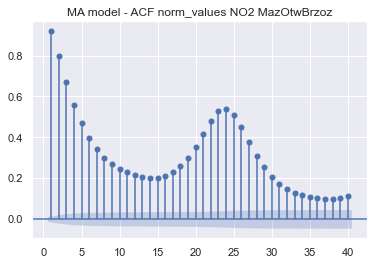

In [56]:
sgt.plot_acf(df_train2.norm_val[1:], lags = 40, zero = False)
plt.title('MA model - ACF norm_values NO2 MazOtwBrzoz')
plt.show()

In [58]:
model_norm_ma_10 = ARMA(df_train2.norm_val[1:], order = (0,8))
results_norm_ma_10 = model_norm_ma_10.fit()
results_norm_ma_10.summary()
#The results shows that:
#- BIC and AIC have been increased
#- LL has been decreased
#- const coeff. has been changed
#- p-values have been remaind the same
#We see that normalizing the input data doesn't affect model selection.

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:               norm_val   No. Observations:                21023
Model:                     ARMA(0, 8)   Log Likelihood              -89117.412
Method:                       css-mle   S.D. of innovations             16.778
Date:                Sun, 08 Nov 2020   AIC                         178254.824
Time:                        11:31:15   BIC                         178334.358
Sample:                    01-01-2017   HQIC                        178280.782
                         - 05-27-2019                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             56.1941      0.774     72.589      0.000      54.677      57.711
ma.L1.norm_val     1.2442      0.007    179.950      0.000       1.231       1.258
ma.L2.norm_val     1.1956      0.011    110.077      0.000       1.174       1.217
ma.L3.norm_val     1.0375      0.013     79.477      0.000       1.012       1.063
ma.L4.norm_val     0.8360      0.014     61.245      0.000       0.809       0.863
ma.L5.norm_val     0.6266      0.013     48.071      0.000       0.601       0.652
ma.L6.norm_val     0.4210      0.012     35.641      0.000       0.398       0.444
ma.L7.norm_val     0.2429      0.010     25.104      0.000       0.224       0.262
ma.L8.norm_val     0.0873      0.006     13.531      0.000       0.075       0.100
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            0.8048           -1.0042j            1.2869           -0.1425
MA.2            0.8048           +1.0042j            1.2869            0.1425
MA.3            0.0047           -1.3393j            1.3393           -0.2494
MA.4            0.0047           +1.3393j            1.3393            0.2494
MA.5           -0.8315           -1.0938j            1.3740           -0.3535
MA.6           -0.8315           +1.0938j            1.3740            0.3535
MA.7           -1.3698           -0.4090j            1.4296           -0.4538
MA.8           -1.3698           +0.4090j            1.4296            0.4538
-----------------------------------------------------------------------------
"""

#### Residuals for normalizing values

In [59]:
df_train2['res_norm_val_ma_10'] = results_norm_ma_10.resid[1:]

Text(0.5, 1.0, 'MA model - Residuals of norm_values NO2 MzOtwBrozo')

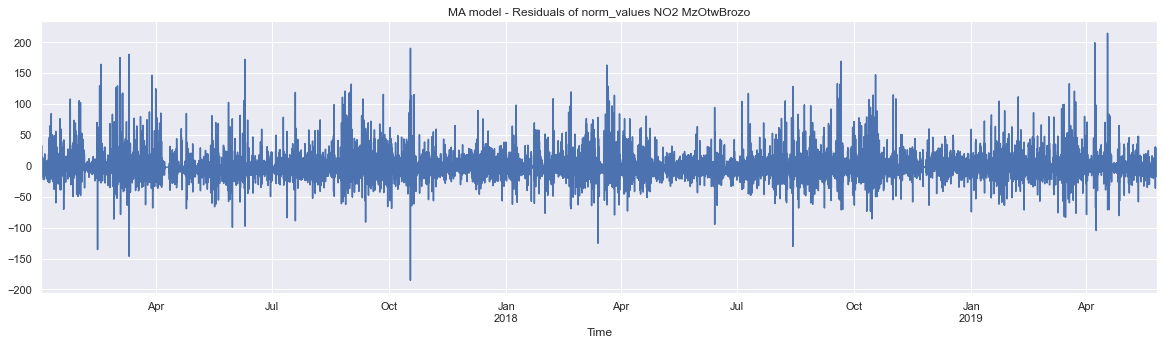

In [60]:
df_train2.res_norm_val_ma_10[1:].plot(figsize=(20,5))
plt.title('MA model - Residuals of norm_values NO2 MzOtwBrozo')

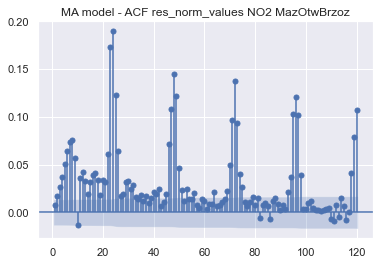

In [62]:
sgt.plot_acf(df_train2.res_norm_val_ma_10[2:], lags = 120, zero = False)
plt.title('MA model - ACF res_norm_values NO2 MazOtwBrzoz')
plt.show()
#ACF of normalized residuals for MA model suggests that the data resembles white noise.
#But unfortuantely, once again we see seasonality effect which we have to include.

# MODEL 3
## ARMA - autoregressive moving-average model

In [63]:
conn = pyodbc.connect('Driver={SQL Server};'
                      'Server=DESKTOP-8RKU8L8;'
                      'Database=GIOŚ;'
                      'Trusted_Connection=yes;')
cursor = conn.cursor()

df_train3 = pd.read_sql_query("""select * from NO2_MzOtwBrzozo_df_train""",conn)
df_train3.set_index('Time', inplace = True)
del df_train3['index'], df_train3['Station_code']

In [64]:
#Before we include the seasonality, we need to understand how the ARMA model works.

In [65]:
model_arma_1 = ARMA(df_train3.Values,order=(1,1))
results_model_arma_1 = model_arma_1.fit()
results_model_arma_1.summary()
#Once more, each coeff. are significant.
#e.g. 0.879 coeff. indicates positive tendency between past and present values.

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                 Values   No. Observations:                21024
Model:                     ARMA(1, 1)   Log Likelihood              -64290.436
Method:                       css-mle   S.D. of innovations              5.150
Date:                Sun, 08 Nov 2020   AIC                         128588.871
Time:                        11:32:40   BIC                         128620.685
Sample:                    01-01-2017   HQIC                        128599.255
                         - 05-27-2019                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           17.3149      0.389     44.550      0.000      16.553      18.077
ar.L1.Values     0.8788      0.003    252.822      0.000       0.872       0.886
ma.L1.Values     0.3273      0.006     51.774      0.000       0.315       0.340
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1380           +0.0000j            1.1380            0.0000
MA.1           -3.0558           +0.0000j            3.0558            0.5000
-----------------------------------------------------------------------------
"""

In [66]:
#We can compare AR and MA models with this one, using LLR test.
#Since AR and MA are nested in ARMA 
print('AR_1 vs. ARMA_1',LLR_test(model_ar,model_arma_1))
print('MA_1 vs. ARMA_1',LLR_test(model_ma_1,model_arma_1))
#Both test results equal 0. 
#This suggests that using past errors in conjunction with past values, result in much better estimates.

AR_1 vs. ARMA_1 0.0
MA_1 vs. ARMA_1 0.0


In [67]:
# With AR and MA models we start from the simplest model and keep on adding lags as they have a significant
# effect on the accuracy of our predictions.
# For ARMA model, we usually diffrent approach. 
# It is reasonable to believe that describing the data would require fewer lags.
# Taking into account error terms would allow A.R. models to calibrate faster and adjust to some huge shocks
# (shocks mean unpredictable significant shifts in value from one period to the next)
# adding pass values would give AM a terms a much better foundation for predictions than the constant factor in the model.


# We'll start with an over parameter rise model with several lags for both the AR and MA components.
# To clarify we're referring to past values and their associated coefficients as AR components and past
# residuals and their associated coefficients as MA components.
# Then start decreasing the number of lags and test different models until we find one with all coefficients significant with a high log
# likelihood and low information criteria.
# We must be aware of overfitting!
# We'll be checking which models approximate the data set to well by fitting the test data.

#### Higher-Lag ARMA models

In [68]:
#First of all, we ought to have a quick glance on ACF and PACF plots. 

#So it makes sense that the optimal ARMA  model would 
#contain fewer components of each type.
#For our case, we expect the preferred ARMA model to contain 
#no more than 2 for AR (look et PACF) and 

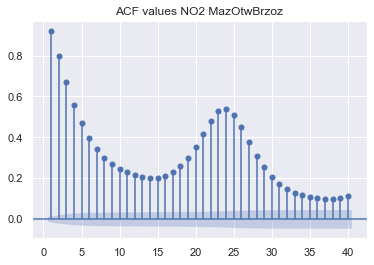

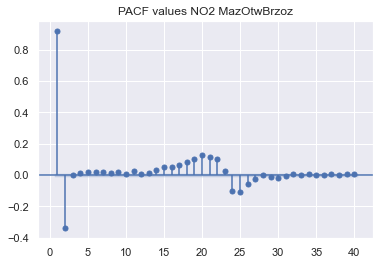

In [69]:
sgt.plot_acf(df_train3.Values, lags = 40, zero = False)
plt.title('ACF values NO2 MazOtwBrzoz')
plt.show()
sgt.plot_pacf(df_train3.Values, lags = 40, zero = False)
plt.title('PACF values NO2 MazOtwBrzoz')
plt.show()

#ACF suggests that all coeff. are significant. 
#This situation resambles non-stationarity data, but according to DF test, our dataset is stationary.
#Of course, we are not able to use infinitely many MA components.
#However, we have known how to deal with it. 
#We remmember that MA model with certain restrictions is equivalent to a simple AR model.
#As long as we include AR components, we should be able to describe the data well by using a finite number of total lags.

In [70]:
model_ar_1_ma_1 = ARMA(df_train3.Values,order=(1,1))
results_model_ar_1_ma_1 = model_ar_1_ma_1.fit()
results_model_ar_1_ma_1.summary()
#Once agian, all coeff. are significant. It could mean that 
#the simple model is not bad choice.

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                 Values   No. Observations:                21024
Model:                     ARMA(1, 1)   Log Likelihood              -64290.436
Method:                       css-mle   S.D. of innovations              5.150
Date:                Sun, 08 Nov 2020   AIC                         128588.871
Time:                        11:46:42   BIC                         128620.685
Sample:                    01-01-2017   HQIC                        128599.255
                         - 05-27-2019                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           17.3149      0.389     44.550      0.000      16.553      18.077
ar.L1.Values     0.8788      0.003    252.822      0.000       0.872       0.886
ma.L1.Values     0.3273      0.006     51.774      0.000       0.315       0.340
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1380           +0.0000j            1.1380            0.0000
MA.1           -3.0558           +0.0000j            3.0558            0.5000
-----------------------------------------------------------------------------
"""

In [71]:
#If is that really true, residuals should show us a white noise. 
df_train3['res_ar_1_ma_1'] = results_model_ar_1_ma_1.resid

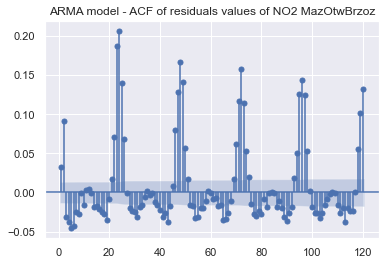

In [77]:
sgt.plot_acf(df_train3.res_ar_1_ma_1, lags = 120, zero = False)
plt.title('ARMA model - ACF of residuals values of NO2 MazOtwBrzoz')
plt.show()
#We see that most of residuals are significant so our model is not a good enough.
#We have captured the effects that were incorporated into... the 0 lag
#without directly including it into our model. Vary bad.

In [73]:
model_ar_6_ma_6 = ARMA(df_train3.Values,order=(6,6))
results_model_ar_6_ma_6 = model_ar_6_ma_6.fit(start_ar_lags = 30)
results_model_ar_6_ma_6.summary()
# ar.L3.Values coeff. is not a significant.
#So we should lower the total number of lags and conduct a trial and error approach.
#That means we should try all models which contain either 6 AR flags or 6 MA lags.
#In this case, this is a highly time consuming.

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                 Values   No. Observations:                21024
Model:                     ARMA(6, 6)   Log Likelihood              -63816.340
Method:                       css-mle   S.D. of innovations              5.035
Date:                Sun, 08 Nov 2020   AIC                         127660.680
Time:                        11:48:51   BIC                         127772.028
Sample:                    01-01-2017   HQIC                        127697.021
                         - 05-27-2019                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           17.3231      0.471     36.767      0.000      16.400      18.247
ar.L1.Values     2.8130      0.022    130.699      0.000       2.771       2.855
ar.L2.Values    -2.7068      0.079    -34.145      0.000      -2.862      -2.551
ar.L3.Values    -0.0747      0.133     -0.561      0.575      -0.336       0.186
ar.L4.Values     2.7410      0.130     21.041      0.000       2.486       2.996
ar.L5.Values    -2.6374      0.074    -35.816      0.000      -2.782      -2.493
ar.L6.Values     0.8582      0.019     45.608      0.000       0.821       0.895
ma.L1.Values    -1.6183      0.022    -72.103      0.000      -1.662      -1.574
ma.L2.Values     0.4305      0.055      7.799      0.000       0.322       0.539
ma.L3.Values     1.2102      0.061     19.695      0.000       1.090       1.331
ma.L4.Values    -1.5827      0.036    -43.836      0.000      -1.653      -1.512
ma.L5.Values     0.4140      0.014     29.552      0.000       0.387       0.441
ma.L6.Values     0.2357      0.009     25.461      0.000       0.218       0.254
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.0096           -0.0000j            1.0096           -0.5000
AR.2            0.5001           -0.8676j            1.0015           -0.1668
AR.3            0.5001           +0.8676j            1.0015            0.1668
AR.4            1.0601           -0.0000j            1.0601           -0.0000
AR.5            1.0111           -0.2513j            1.0419           -0.0388
AR.6            1.0111           +0.2513j            1.0419            0.0388
MA.1            0.5016           -0.8710j            1.0051           -0.1668
MA.2            0.5016           +0.8710j            1.0051            0.1668
MA.3            1.0273           -0.1956j            1.0457           -0.0299
MA.4            1.0273           +0.1956j            1.0457            0.0299
MA.5           -1.0094           -0.0000j            1.0094           -0.5000
MA.6           -3.8052           -0.0000j            3.8052           -0.5000
-----------------------------------------------------------------------------
"""

In [74]:
model_ar_2_ma_6 = ARMA(df_train3.Values,order=(2,6))
results_model_ar_2_ma_6 = model_ar_2_ma_6.fit(start_ar_lags = 30)
results_model_ar_2_ma_6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                 Values   No. Observations:                21024
Model:                     ARMA(2, 6)   Log Likelihood              -63979.347
Method:                       css-mle   S.D. of innovations              5.074
Date:                Sun, 08 Nov 2020   AIC                         127978.694
Time:                        11:49:47   BIC                         128058.228
Sample:                    01-01-2017   HQIC                        128004.652
                         - 05-27-2019                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           17.2966      0.876     19.751      0.000      15.580      19.013
ar.L1.Values     1.6710      0.017     96.758      0.000       1.637       1.705
ar.L2.Values    -0.6735      0.017    -39.631      0.000      -0.707      -0.640
ma.L1.Values    -0.4521      0.018    -24.650      0.000      -0.488      -0.416
ma.L2.Values    -0.2115      0.008    -25.331      0.000      -0.228      -0.195
ma.L3.Values    -0.1139      0.008    -14.548      0.000      -0.129      -0.099
ma.L4.Values    -0.0768      0.009     -8.992      0.000      -0.094      -0.060
ma.L5.Values    -0.0475      0.009     -5.346      0.000      -0.065      -0.030
ma.L6.Values    -0.0362      0.009     -4.071      0.000      -0.054      -0.019
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0077           +0.0000j            1.0077            0.0000
AR.2            1.4735           +0.0000j            1.4735            0.0000
MA.1            1.0304           -0.0000j            1.0304           -0.0000
MA.2            0.8560           -1.6308j            1.8418           -0.1731
MA.3            0.8560           +1.6308j            1.8418            0.1731
MA.4           -1.9876           -0.0000j            1.9876           -0.5000
MA.5           -1.0334           -1.7049j            1.9937           -0.3367
MA.6           -1.0334           +1.7049j            1.9937            0.3367
-----------------------------------------------------------------------------
"""

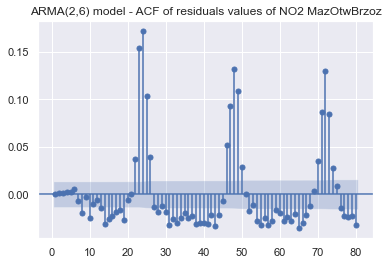

In [79]:
#Finally, we are able to confirm (again) that the model we analyzing is not a good choice.
#Residuals of good model ought to remable white nosie and most of them should be unsignificnat.
#As we can see below on the plot, the residuals don't resamble white noise. 
df_train3['res_model_ar_2_ma_6'] = results_model_ar_2_ma_6.resid
sgt.plot_acf(df_train3.res_model_ar_2_ma_6, lags = 80, zero = False)
plt.title('ARMA(2,6) model - ACF of residuals values of NO2 MazOtwBrzoz')
plt.show()
#We have captured the effects that were incorporated into the 7th lag
#without directly including it into our model.
#We still see some significant coefficients many lags into the past 
#but we know that the further back in time we go the less relevant the values become.

In [76]:
#The better model, the higher LL and lower AIC.
#Both parameters haven't changed.
#Based on this test, we can't conclude which of these models are better.
print('ARMA(6,6) LL=', results_model_ar_6_ma_6.llf,'AIC=',results_model_ar_6_ma_6.aic)
print('ARMA(2,6) LL=', results_model_ar_2_ma_6.llf,'AIC=',results_model_ar_2_ma_6.aic)

ARMA(6,6) LL= -63816.33981457846 AIC= 127660.67962915692
ARMA(2,6) LL= -63979.34687387686 AIC= 127978.69374775371


# MODEL 4
## ARIMA - autoregressive integrated moving-average model

In [ ]:
#In this part od code we will only examined models with a single degree of integration since we assume it is sufficient.
#D-F test shows that data is stationarity, but coeff. on the ACF plot are significant diffrent then 0.
#Hence, if a single layer of integration accomplishes this, any additional ones are unnecessary.
#Of course, we can manually create an integrated version of the original time series and use the Augmented Dickey-Fuller test.

In [80]:
conn = pyodbc.connect('Driver={SQL Server};'
                      'Server=DESKTOP-8RKU8L8;'
                      'Database=GIOŚ;'
                      'Trusted_Connection=yes;')
cursor = conn.cursor()

df_train4 = pd.read_sql_query("""select * from NO2_MzOtwBrzozo_df_train""",conn)
df_train4.set_index('Time', inplace = True)
del df_train4['index'], df_train4['Station_code']

#### Augmented Dickey-Fuller test

In [81]:
df_train4['delta_values'] = df_train4.Values.diff(1)
#ARMA(P,Q) for our manually created delta_values = ARIMA(P,1,Q)
#ARMA(P,Q) = ARIMA(P,0,Q)

In [82]:
#After this operation, we have no doubts that our data comes from stationary process.
#It means we have no need for additional layers of integration.
#(d>1 is not recommended).
#We must know that the more unnecessary layers we add, the more our model suffers (it becomes less accurate).
#Also, the more layers we add, the harder it is to interpret the results.
#The coeff. wouldn't be the difference between NO2 values or even some slope of their changes.
sts.adfuller(df_train4[1:].delta_values)

(-35.61716266163323,
 0.0,
 45,
 20977,
 {'1%': -3.4306617748195767,
  '5%': -2.8616777938661917,
  '10%': -2.5668433438484324},
 125881.22169487775)

#### ARIMA(1,1,1)

In [83]:
model_ar_1_i_1_ma_1 = ARIMA(df_train4.Values, order=(1,1,1))
results_ar_1_i_1_ma_1 = model_ar_1_i_1_ma_1.fit()
results_ar_1_i_1_ma_1.summary()
#We see that 2 coeff.(phi, theta) are significant diffrent then 0.
#Constanr C is not.
#d - order is in between them.
#The integration order has no effect on the number of parameters we need to estimate.
#We are transforming the underlying data while no modeling is performed.

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D.Values   No. Observations:                21023
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -64906.031
Method:                       css-mle   S.D. of innovations              5.304
Date:                Sun, 08 Nov 2020   AIC                         129820.061
Time:                        12:11:12   BIC                         129851.875
Sample:                    01-01-2017   HQIC                        129830.444
                         - 05-27-2019                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0003      0.049     -0.006      0.995      -0.097       0.096
ar.L1.D.Values     0.1302      0.020      6.478      0.000       0.091       0.170
ma.L1.D.Values     0.1737      0.020      8.839      0.000       0.135       0.212
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            7.6829           +0.0000j            7.6829            0.0000
MA.1           -5.7565           +0.0000j            5.7565            0.5000
-----------------------------------------------------------------------------
"""

#### Residuals of ARIMA(1,1,1)

In [84]:
df_train4['res_val_ar_1_i_1_ma_1'] = results_ar_1_i_1_ma_1.resid

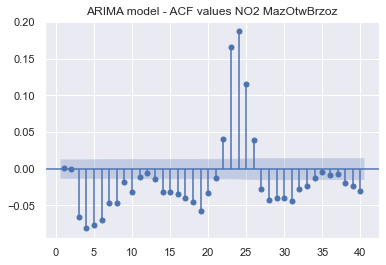

In [85]:
sgt.plot_acf(df_train4.res_val_ar_1_i_1_ma_1[1:], lags = 40, zero = False)
plt.title('ARIMA model - ACF values NO2 MazOtwBrzoz')
plt.show()
#We observe that most of coeff. are signifcant. For us it is not a good information,
#because all of them should have been included. The model has failed.

#### Higher lags model ARIMA

In [86]:
model_ar_2_i_1_ma_1 = ARIMA(df_train4.Values, order=(2,1,1))
results_ar_2_i_1_ma_1 = model_ar_2_i_1_ma_1.fit()
results_ar_2_i_1_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D.Values   No. Observations:                21023
Model:                 ARIMA(2, 1, 1)   Log Likelihood              -64011.215
Method:                       css-mle   S.D. of innovations              5.083
Date:                Sun, 08 Nov 2020   AIC                         128032.429
Time:                        12:11:25   BIC                         128072.196
Sample:                    01-01-2017   HQIC                        128045.408
                         - 05-27-2019                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0003      0.004     -0.083      0.934      -0.008       0.007
ar.L1.D.Values     1.2160      0.007    182.840      0.000       1.203       1.229
ar.L2.D.Values    -0.3570      0.007    -54.414      0.000      -0.370      -0.344
ma.L1.D.Values    -0.9843      0.002   -411.072      0.000      -0.989      -0.980
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.3878           +0.0000j            1.3878            0.0000
AR.2            2.0185           +0.0000j            2.0185            0.0000
MA.1            1.0160           +0.0000j            1.0160            0.0000
-----------------------------------------------------------------------------
"""

In [87]:
model_ar_2_i_1_ma_2 = ARIMA(df_train4.Values, order=(2,1,2))
results_ar_2_i_1_ma_2 = model_ar_2_i_1_ma_2.fit()
results_ar_2_i_1_ma_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D.Values   No. Observations:                21023
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -64001.873
Method:                       css-mle   S.D. of innovations              5.080
Date:                Sun, 08 Nov 2020   AIC                         128015.746
Time:                        12:11:43   BIC                         128063.466
Sample:                    01-01-2017   HQIC                        128031.321
                         - 05-27-2019                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0003      0.005     -0.062      0.950      -0.009       0.009
ar.L1.D.Values     1.2942      0.019     69.283      0.000       1.258       1.331
ar.L2.D.Values    -0.4309      0.018    -24.497      0.000      -0.465      -0.396
ma.L1.D.Values    -1.0735      0.021    -51.851      0.000      -1.114      -1.033
ma.L2.D.Values     0.0912      0.021      4.352      0.000       0.050       0.132
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.5017           -0.2559j            1.5234           -0.0269
AR.2            1.5017           +0.2559j            1.5234            0.0269
MA.1            1.0199           +0.0000j            1.0199            0.0000
MA.2           10.7550           +0.0000j           10.7550            0.0000
-----------------------------------------------------------------------------
"""

In [88]:
model_ar_3_i_1_ma_1 = ARIMA(df_train4.Values, order=(3,1,1))
results_ar_3_i_1_ma_1 = model_ar_3_i_1_ma_1.fit()
results_ar_3_i_1_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D.Values   No. Observations:                21023
Model:                 ARIMA(3, 1, 1)   Log Likelihood              -64002.974
Method:                       css-mle   S.D. of innovations              5.081
Date:                Sun, 08 Nov 2020   AIC                         128017.947
Time:                        12:12:00   BIC                         128065.668
Sample:                    01-01-2017   HQIC                        128033.522
                         - 05-27-2019                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0003      0.004     -0.065      0.948      -0.009       0.008
ar.L1.D.Values     1.2034      0.007    164.606      0.000       1.189       1.218
ar.L2.D.Values    -0.3229      0.011    -30.360      0.000      -0.344      -0.302
ar.L3.D.Values    -0.0293      0.007     -4.070      0.000      -0.043      -0.015
ma.L1.D.Values    -0.9812      0.002   -392.622      0.000      -0.986      -0.976
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.5419           -0.2061j            1.5557           -0.0212
AR.2            1.5419           +0.2061j            1.5557            0.0212
AR.3          -14.1107           -0.0000j           14.1107           -0.5000
MA.1            1.0191           +0.0000j            1.0191            0.0000
-----------------------------------------------------------------------------
"""

In [89]:
#Trial and error method:
model_ar_3_i_1_ma_3 = ARIMA(df_train4.Values, order=(3,1,3))
results_ar_3_i_1_ma_3 = model_ar_3_i_1_ma_3.fit()
results_ar_3_i_1_ma_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D.Values   No. Observations:                21023
Model:                 ARIMA(3, 1, 3)   Log Likelihood              -63998.970
Method:                       css-mle   S.D. of innovations              5.080
Date:                Sun, 08 Nov 2020   AIC                         128013.940
Time:                        12:12:33   BIC                         128077.567
Sample:                    01-01-2017   HQIC                        128034.707
                         - 05-27-2019                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0003      0.005     -0.060      0.952      -0.009       0.009
ar.L1.D.Values     0.4620      0.111      4.152      0.000       0.244       0.680
ar.L2.D.Values     0.6687      0.134      4.985      0.000       0.406       0.932
ar.L3.D.Values    -0.3798      0.043     -8.828      0.000      -0.464      -0.295
ma.L1.D.Values    -0.2410      0.112     -2.159      0.031      -0.460      -0.022
ma.L2.D.Values    -0.8289      0.109     -7.630      0.000      -1.042      -0.616
ma.L3.D.Values     0.1029      0.021      4.984      0.000       0.062       0.143
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.1763           -0.0000j            1.1763           -0.5000
AR.2            1.4686           -0.2858j            1.4962           -0.0306
AR.3            1.4686           +0.2858j            1.4962            0.0306
MA.1            1.0206           +0.0000j            1.0206            0.0000
MA.2           -1.1617           +0.0000j            1.1617            0.5000
MA.3            8.1972           +0.0000j            8.1972            0.0000
-----------------------------------------------------------------------------
"""

In [90]:
#Trial and error method:
model_ar_4_i_1_ma_1 = ARIMA(df_train4.Values, order=(4,1,1))
results_ar_4_i_1_ma_1 = model_ar_4_i_1_ma_1.fit()
results_ar_4_i_1_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D.Values   No. Observations:                21023
Model:                 ARIMA(4, 1, 1)   Log Likelihood              -63998.589
Method:                       css-mle   S.D. of innovations              5.080
Date:                Sun, 08 Nov 2020   AIC                         128011.179
Time:                        12:13:00   BIC                         128066.852
Sample:                    01-01-2017   HQIC                        128029.349
                         - 05-27-2019                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0003      0.005     -0.057      0.955      -0.010       0.009
ar.L1.D.Values     1.2005      0.007    162.994      0.000       1.186       1.215
ar.L2.D.Values    -0.3286      0.011    -30.443      0.000      -0.350      -0.307
ar.L3.D.Values    -0.0055      0.011     -0.505      0.613      -0.027       0.016
ar.L4.D.Values    -0.0214      0.007     -2.966      0.003      -0.036      -0.007
ma.L1.D.Values    -0.9789      0.003   -370.984      0.000      -0.984      -0.974
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.4214           -0.3153j            1.4560           -0.0347
AR.2            1.4214           +0.3153j            1.4560            0.0347
AR.3           -1.5487           -4.4313j            4.6941           -0.3035
AR.4           -1.5487           +4.4313j            4.6941            0.3035
MA.1            1.0216           +0.0000j            1.0216            0.0000
-----------------------------------------------------------------------------
"""

In [91]:
#Trial and error method:
model_ar_4_i_1_ma_2 = ARIMA(df_train4.Values, order=(4,1,2))
results_ar_4_i_1_ma_2 = model_ar_4_i_1_ma_2.fit()
results_ar_4_i_1_ma_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D.Values   No. Observations:                21023
Model:                 ARIMA(4, 1, 2)   Log Likelihood              -64000.140
Method:                       css-mle   S.D. of innovations              5.080
Date:                Sun, 08 Nov 2020   AIC                         128016.280
Time:                        12:13:35   BIC                         128079.907
Sample:                    01-01-2017   HQIC                        128037.047
                         - 05-27-2019                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0003      0.005     -0.063      0.949      -0.009       0.009
ar.L1.D.Values     0.3419      0.095      3.603      0.000       0.156       0.528
ar.L2.D.Values     0.7101      0.115      6.160      0.000       0.484       0.936
ar.L3.D.Values    -0.2973      0.034     -8.625      0.000      -0.365      -0.230
ar.L4.D.Values    -0.0339      0.007     -4.720      0.000      -0.048      -0.020
ma.L1.D.Values    -0.1197      0.095     -1.264      0.206      -0.305       0.066
ma.L2.D.Values    -0.8444      0.093     -9.054      0.000      -1.027      -0.662
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.1766           -0.0000j            1.1766           -0.5000
AR.2            1.5166           -0.2419j            1.5358           -0.0252
AR.3            1.5166           +0.2419j            1.5358            0.0252
AR.4          -10.6166           -0.0000j           10.6166           -0.5000
MA.1            1.0196           +0.0000j            1.0196            0.0000
MA.2           -1.1614           +0.0000j            1.1614            0.5000
-----------------------------------------------------------------------------
"""

In [92]:
#Trial and error method:
model_ar_5_i_1_ma_1 = ARIMA(df_train4.Values, order=(5,1,1))
results_ar_5_i_1_ma_1 = model_ar_5_i_1_ma_1.fit()
results_ar_5_i_1_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D.Values   No. Observations:                21023
Model:                 ARIMA(5, 1, 1)   Log Likelihood              -63997.267
Method:                       css-mle   S.D. of innovations              5.079
Date:                Sun, 08 Nov 2020   AIC                         128010.533
Time:                        12:14:08   BIC                         128074.160
Sample:                    01-01-2017   HQIC                        128031.300
                         - 05-27-2019                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0003      0.005     -0.053      0.958      -0.010       0.009
ar.L1.D.Values     1.1989      0.007    161.359      0.000       1.184       1.213
ar.L2.D.Values    -0.3283      0.011    -30.437      0.000      -0.349      -0.307
ar.L3.D.Values    -0.0091      0.011     -0.825      0.409      -0.031       0.012
ar.L4.D.Values    -0.0084      0.011     -0.777      0.437      -0.030       0.013
ar.L5.D.Values    -0.0118      0.007     -1.628      0.104      -0.026       0.002
ma.L1.D.Values    -0.9775      0.003   -349.881      0.000      -0.983      -0.972
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.3598           -0.3342j            1.4002           -0.0384
AR.2            1.3598           +0.3342j            1.4002            0.0384
AR.3            0.3119           -3.2508j            3.2657           -0.2348
AR.4            0.3119           +3.2508j            3.2657            0.2348
AR.5           -4.0534           -0.0000j            4.0534           -0.5000
MA.1            1.0230           +0.0000j            1.0230            0.0000
-----------------------------------------------------------------------------
"""

In [93]:
#We can print out log likelihoods of all fitted models and their AIC to determine which model is the best fit.
print('ARIMA(1,1,1) LL=', results_ar_1_i_1_ma_1.llf,'AIC=',results_ar_1_i_1_ma_1.aic)
print('ARIMA(2,1,1) LL=', results_ar_2_i_1_ma_1.llf,'AIC=',results_ar_2_i_1_ma_1.aic)
print('ARIMA(2,1,2) LL=', results_ar_2_i_1_ma_2.llf,'AIC=',results_ar_2_i_1_ma_2.aic)
print('ARIMA(3,1,1) LL=', results_ar_3_i_1_ma_1.llf,'AIC=',results_ar_3_i_1_ma_1.aic)
print('ARIMA(3,1,3) LL=', results_ar_3_i_1_ma_3.llf,'AIC=',results_ar_3_i_1_ma_3.aic)
print('ARIMA(4,1,1) LL=', results_ar_4_i_1_ma_1.llf,'AIC=',results_ar_4_i_1_ma_1.aic)
print('ARIMA(4,1,2) LL=', results_ar_4_i_1_ma_2.llf,'AIC=',results_ar_4_i_1_ma_2.aic)
print('ARIMA(5,1,1) LL=', results_ar_5_i_1_ma_1.llf,'AIC=',results_ar_5_i_1_ma_1.aic)
#We are seeking the model with the lowest AIC and the highest LL.
#ARIMA(5,1,1) immediately becomes the front runner of our short list but that's not all.
#ARIMA(1,1,1),ARIMA(2,1,1),ARIMA(3,1,1),and ARIMA(4,1,1) are nested in ARIMA(5,1,1),
#hence, we need to run LLR_test to make sure it significantly outperforms them.

ARIMA(1,1,1) LL= -64906.03055967692 AIC= 129820.06111935384
ARIMA(2,1,1) LL= -64011.21456474795 AIC= 128032.4291294959
ARIMA(2,1,2) LL= -64001.87312261986 AIC= 128015.74624523972
ARIMA(3,1,1) LL= -64002.97365387273 AIC= 128017.94730774546
ARIMA(3,1,3) LL= -63998.9701355593 AIC= 128013.9402711186
ARIMA(4,1,1) LL= -63998.58933336496 AIC= 128011.17866672992
ARIMA(4,1,2) LL= -64000.13996629059 AIC= 128016.27993258118
ARIMA(5,1,1) LL= -63997.26664918866 AIC= 128010.53329837733


In [94]:
print(LLR_test(model_ar_1_i_1_ma_1,model_ar_2_i_1_ma_1))
print(LLR_test(model_ar_2_i_1_ma_1,model_ar_3_i_1_ma_1))
print(LLR_test(model_ar_3_i_1_ma_1,model_ar_4_i_1_ma_1))
print(LLR_test(model_ar_4_i_1_ma_1,model_ar_5_i_1_ma_1))
#Except of the last one, test values is zeros which indicates that the higher complexity is necessary.
#ARIMA(4,1,1) appears to be the best choice.

0.0
0.0
0.003
0.104


#### Residuals of ARIMA(4,1,1)

In [95]:
#Only if they resemble white noise we'll proceed with 
#examining and discussing the parameters from the summary table.
#Otherwise we'll try to find a better fitting model.
df_train4['res_val_ar_4_i_1_ma_1'] = results_ar_4_i_1_ma_1.resid

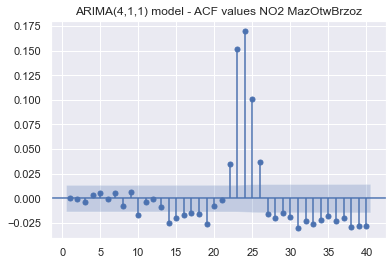

In [96]:
sgt.plot_acf(df_train4.res_val_ar_4_i_1_ma_1[1:], lags = 40, zero = False)
plt.title('ARIMA(4,1,1) model - ACF values NO2 MazOtwBrzoz')
plt.show()
#It's much better then ARMIA(1,1,1) but still unsuffcient (coeff. don't resamble white noise).
#We have captured the effects that were incorporated into the 9th lag
#without directly including it into our model.
#We still see some significant coefficients many lags into the past 
#but we know that the further back in time we go the less relevant the values become.
#Unfortunatelly, these coeff. (lag 22-26) are largely significant.

# MODELS 5
## SARMA & SARIMA
#### (models in preparation)

In [27]:
conn = pyodbc.connect('Driver={SQL Server};'
                      'Server=DESKTOP-8RKU8L8;'
                      'Database=GIOŚ;'
                      'Trusted_Connection=yes;')
cursor = conn.cursor()

df_train5 = pd.read_sql_query("""select * from NO2_MzOtwBrzozo_df_train""",conn)
df_train5.set_index('Time', inplace = True)
del df_train5['index'], df_train5['Station_code']

#### SARMA(2,0,2)(1,0,1,24)

In [29]:
model_sarma = SARIMAX(df_train5.Values, order=(2,0,2), seasonal_order = (1,0,1,24))
results_sarma = model_sarma.fit()
results_sarma.summary()

In [ ]:
df_train5['sarma_res_values'] = results_sarma.resid

In [ ]:
sgt.plot_acf(df_train5.sarma_res_values[1:], lags = 40, zero = False)
plt.title('SARMA(2,0,4)(1,0,1,24) model - ACF values NO2 MazOtwBrzoz')
plt.show()

In [ ]:
df_train5.sarma_res_values[1:].plot(figsize=(20,5))
plt.title('SARMA model - residuals of NO2 MazOtwBrzoz')
plt.show()

In [ ]:
sts.adfuller(df_train5.sarma_res_values[1:])

#### SARIMA(2,1,2)(1,1,1,24)

In [8]:
model_sarima = SARIMAX(df_train5.Values, order=(2,1,2), seasonal_order = (1,1,1,24))
results_sarima = model_sarima.fit()
results_sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                               Values   No. Observations:                21024
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 24)   Log Likelihood              -63042.016
Date:                              Wed, 11 Nov 2020   AIC                         126098.033
Time:                                      10:17:33   BIC                         126153.698
Sample:                                  01-01-2017   HQIC                        126116.202
                                       - 05-27-2019                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0194      0.019     54.801      0.000       0.983       1.056
ar.L2         -0.1545      0.017     -8.992      0.000      -0.188      -0.121
ma.L1         -0.8984      0.019    -48.210      0.000      -0.935      -0.862
ma.L2         -0.0958      0.019     -5.152      0.000      -0.132      -0.059
ar.S.L24       0.0877      0.004     19.909      0.000       0.079       0.096
ma.S.L24      -0.9445      0.002   -579.660      0.000      -0.948      -0.941
sigma2        23.6631      0.082    288.058      0.000      23.502      23.824
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            226627.46
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.84   Skew:                             1.25
Prob(H) (two-sided):                  0.00   Kurtosis:                        18.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [9]:
df_train5['sarima_res_values'] = results_sarima.resid

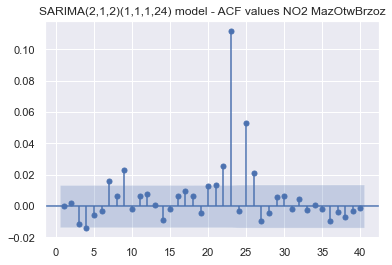

In [10]:
sgt.plot_acf(df_train5.sarima_res_values[1:], lags = 40, zero = False)
plt.title('SARIMA(2,1,2)(1,1,1,24) model - ACF values NO2 MazOtwBrzoz')
plt.show()

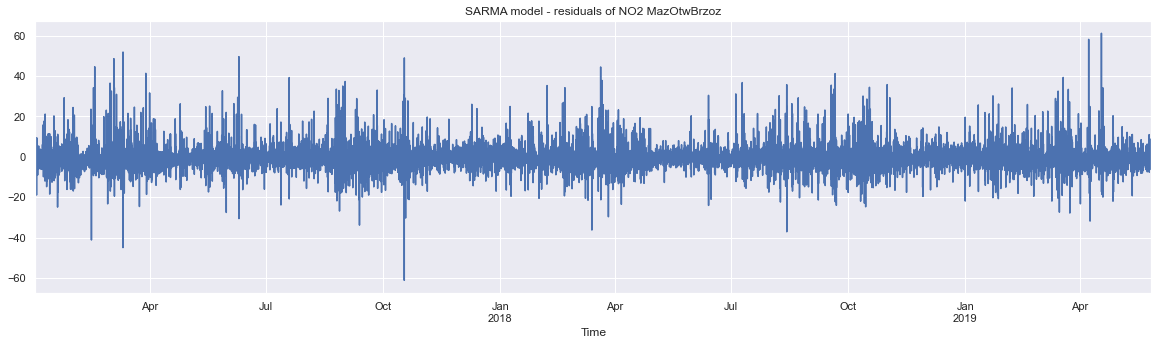

In [18]:
df_train5.sarima_res_values[1:].plot(figsize=(20,5))
plt.title('SARMA model - residuals of NO2 MazOtwBrzoz')
plt.show()

In [19]:
sts.adfuller(df_train5.sarima_res_values[1:])

(-22.257281687990535,
 0.0,
 25,
 20997,
 {'1%': -3.4306614778124356,
  '5%': -2.8616776626060236,
  '10%': -2.5668432739810934},
 125593.20835349796)

In [11]:
#Which one is better?
#Our models (SARMA and SARIMA) have all coeff. significantly 
#different from 0. SARIMA is more complex beacuse of integration.
#We also know that both models have the same degrees of freedom (num. of lags).
#Thus, instead of LLR-test, we need to compare their information criteria. 
# We opt for the model with lower AIC and BIC coefficients.

In [16]:
print('SARMA AIC '+str(round(results_sarma.aic,2)), 'SARIMA AIC '+str(round(results_sarima.aic,2)))

#Models residuals resamble white nosie.
#We are able to conlude there is no other pattern we can account for without overtraining each model.
#The diference between AIC is rather insignificant.
#Examining their ACF residuals we see that SARIMA model captured much more coeff.

SARMA AIC 126138.9 SARIMA AIC 126098.03


In [ ]:
#We can conclude that SARMA, as a simplest model with similar AIC and LL, is a better then ARIMA 
#and integration is not needed. At the end of analysis in the section Summary,
#we compared predictions to actual value dwonladed directly form station MzOtwBrzozo.

# MODELS 6
## SARMAX, SARIMAX 
#### (models in preparation)

In [ ]:
#The idea of X models is to adding a new exogenous variable/s to our model.
#Additionaly, we are going to include integration and seasonality, but the common for any of these models is: 
#incorporate past values (AR) and past resiudals (MA).
#We purposely ommit models ARMAX and ARIMAX since until now we have obtained enough evidences for seasonality.  
#Actually, we have unlimited possibilities testing models e.g. we can check how to model behave if we add other parameter of air pollution (SO2, CO2, O3 etc.),
#or some meteorological data.

In [285]:
conn = pyodbc.connect('Driver={SQL Server};'
                      'Server=DESKTOP-8RKU8L8;'
                      'Database=GIOŚ;'
                      'Trusted_Connection=yes;')
cursor = conn.cursor()

df_train6 = pd.read_sql_query("""select * from NO2_MzOtwBrzozo_df_train""",conn)
df_train6.set_index('Time', inplace = True)
del df_train6['index'], df_train6['Station_code']

#### SARMAX(2,0,2)(1,0,1,24) exog = weekend

In [286]:
#Let's create some new variables and check if they will helps.
df_train6['weekday'] = df_train6.index.weekday
df_train6['hours'] = df_train6.index.hour
df_train6['weekend'] = [1 if x >= 5 else 0 for x in df_train6['weekday']]
#The trial and error method has proved that
#weekday variable is insignificant.

In [101]:
SO2_stat = SO2_data17.loc[SO2_data17['Station_code'] == chosen_station]
SO2_stat = SO2_stat.append(SO2_data18.loc[SO2_data18['Station_code'] == chosen_station])
SO2_stat = SO2_stat.append(SO2_data19.loc[SO2_data19['Station_code'] == chosen_station])

export_df_to_MSSQL(SO2_stat,'DESKTOP-8RKU8L8',
                       'GIOŚ','MzOtwoBrzozo_SO2_stat')

(26280,)

In [433]:
df_SO2 = pd.read_sql_query("""select * from MzOtwoBrzozo_SO2_stat""",conn)
df_SO2['Values'].isna().sum()

552

In [434]:
df_SO2['Values'] = [float(x) for x in df_SO2['Values']]

In [435]:
df_SO2['Values'].median()

3.5

In [438]:
df_SO2['Values'] = df_SO2['Values'].fillna(df_SO2['Values'].median())

In [439]:
df_SO2['Values'].isna().sum()

0

In [440]:
df_SO2['Values'].sum()

469595.245

In [441]:
size_SO2 = int(len(df_SO2)*0.8)
df_SO2_train = df_SO2.iloc[:size_SO2]

In [442]:
df_SO2_train = df_SO2_train.set_index('Time')

In [443]:
df_train6['Values_SO2'] = [x for x in df_SO2_train['Values']]

In [444]:
df_train6['Values_SO2'].isna().sum()

0

In [445]:
df_train6['Values_SO2'] = df_train6['Values_SO2'].fillna(df_train6['Values_SO2'].median)

In [447]:
model_sarmax = SARIMAX(df_train6.Values, exog=df_train6.Values_SO2, order=(2,0,2), seasonal_order = (1,0,1,24))
results_sarmax = model_sarmax.fit()
results_sarmax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                               Values   No. Observations:                21024
Model:             SARIMAX(2, 0, 2)x(1, 0, [1], 24)   Log Likelihood              -62723.930
Date:                              Thu, 12 Nov 2020   AIC                         125463.860
Time:                                      15:17:05   BIC                         125527.487
Sample:                                  01-01-2017   HQIC                        125484.626
                                       - 05-27-2019                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Values_SO2    -0.1391      0.002    -79.638      0.000      -0.143      -0.136
ar.L1          0.7662      0.199      3.856      0.000       0.377       1.156
ar.L2          0.0916      0.175      0.525      0.600      -0.251       0.434
ma.L1          0.3506      0.199      1.763      0.078      -0.039       0.740
ma.L2          0.0549      0.047      1.178      0.239      -0.036       0.146
ar.S.L24       0.9905      0.001   1005.005      0.000       0.989       0.992
ma.S.L24      -0.9166      0.002   -391.717      0.000      -0.921      -0.912
sigma2        22.8194      0.083    276.574      0.000      22.658      22.981
===================================================================================
Ljung-Box (L1) (Q):                   0.16   Jarque-Bera (JB):            264658.40
Prob(Q):                              0.69   Prob(JB):                         0.00
Heteroskedasticity (H):               0.73   Skew:                             1.33
Prob(H) (two-sided):                  0.00   Kurtosis:                        20.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [448]:
model_sarmax2 = SARIMAX(df_train6.Values, exog=df_train6.Values_SO2, order=(1,0,1), seasonal_order = (1,0,1,24))
results_sarmax2 = model_sarmax2.fit()
results_sarmax2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                             Values   No. Observations:                21024
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 24)   Log Likelihood              -62731.205
Date:                            Thu, 12 Nov 2020   AIC                         125474.410
Time:                                    15:34:49   BIC                         125522.131
Sample:                                01-01-2017   HQIC                        125489.985
                                     - 05-27-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Values_SO2    -0.1402      0.002    -80.433      0.000      -0.144      -0.137
ar.L1          0.8783      0.002    392.741      0.000       0.874       0.883
ma.L1          0.2327      0.003     68.535      0.000       0.226       0.239
ar.S.L24       0.9901      0.001    990.041      0.000       0.988       0.992
ma.S.L24      -0.9154      0.002   -389.306      0.000      -0.920      -0.911
sigma2        22.8388      0.082    277.252      0.000      22.677      23.000
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):            264710.35
Prob(Q):                              0.72   Prob(JB):                         0.00
Heteroskedasticity (H):               0.73   Skew:                             1.34
Prob(H) (two-sided):                  0.00   Kurtosis:                        20.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [50]:
model_sarmax3 = SARIMAX(df_train6.Values, exog=df_train6.hours, order=(2,0,2), seasonal_order = (1,0,1,24))
results_sarmax3 = model_sarmax3.fit()
results_sarmax3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                               Values   No. Observations:                21024
Model:             SARIMAX(2, 0, 2)x(1, 0, [1], 24)   Log Likelihood              -63108.934
Date:                              Thu, 12 Nov 2020   AIC                         126233.869
Time:                                      10:35:43   BIC                         126297.496
Sample:                                  01-01-2017   HQIC                        126254.635
                                       - 05-27-2019                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
hours          0.1700      0.054      3.121      0.002       0.063       0.277
ar.L1          0.7524      0.149      5.035      0.000       0.459       1.045
ar.L2          0.0932      0.130      0.716      0.474      -0.162       0.348
ma.L1          0.3760      0.150      2.513      0.012       0.083       0.669
ma.L2          0.0693      0.038      1.835      0.067      -0.005       0.143
ar.S.L24       0.9866      0.001    845.867      0.000       0.984       0.989
ma.S.L24      -0.9078      0.002   -364.873      0.000      -0.913      -0.903
sigma2        23.6796      0.087    271.445      0.000      23.509      23.851
===================================================================================
Ljung-Box (L1) (Q):                   0.15   Jarque-Bera (JB):            242669.55
Prob(Q):                              0.69   Prob(JB):                         0.00
Heteroskedasticity (H):               0.84   Skew:                             1.36
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [51]:
print('LLR tests p-values:')
print(LLR_test(model_sarmax2, model_sarmax))

LLR tests p-values:
1.0


#### SARIMAX(1,1,1)(1,1,1,24) exog = SO2

In [449]:
model_sarimax = SARIMAX(df_train6.Values, exog=df_train6.Values_SO2, order=(1,1,1), seasonal_order = (1,0,1,24))
results_sarimax = model_sarimax.fit()
results_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                             Values   No. Observations:                21024
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 24)   Log Likelihood              -63320.369
Date:                            Thu, 12 Nov 2020   AIC                         126652.738
Time:                                    15:47:19   BIC                         126700.459
Sample:                                01-01-2017   HQIC                        126668.313
                                     - 05-27-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Values_SO2    -0.1488      0.002    -87.363      0.000      -0.152      -0.145
ar.L1         -0.1295      0.023     -5.698      0.000      -0.174      -0.085
ma.L1          0.3075      0.022     14.071      0.000       0.265       0.350
ar.S.L24       0.9756      0.002    513.350      0.000       0.972       0.979
ma.S.L24      -0.9020      0.003   -274.808      0.000      -0.908      -0.896
sigma2        24.1791      0.084    288.869      0.000      24.015      24.343
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):            265658.74
Prob(Q):                              0.74   Prob(JB):                         0.00
Heteroskedasticity (H):               0.75   Skew:                             0.80
Prob(H) (two-sided):                  0.00   Kurtosis:                        20.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [450]:
model_sarimax = SARIMAX(df_train6.Values, exog=df_train6.Values_SO2, order=(1,1,1), seasonal_order = (1,1,1,24))
results_sarimax = model_sarimax.fit()
results_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                             Values   No. Observations:                21024
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 24)   Log Likelihood              -63311.634
Date:                            Thu, 12 Nov 2020   AIC                         126635.267
Time:                                    15:51:34   BIC                         126682.980
Sample:                                01-01-2017   HQIC                        126650.841
                                     - 05-27-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Values_SO2    -0.1495      0.002    -86.374      0.000      -0.153      -0.146
ar.L1         -0.1472      0.024     -6.175      0.000      -0.194      -0.100
ma.L1          0.3193      0.023     13.945      0.000       0.274       0.364
ar.S.L24       0.0759      0.004     17.169      0.000       0.067       0.085
ma.S.L24      -0.9444      0.002   -557.894      0.000      -0.948      -0.941
sigma2        24.2812      0.083    291.991      0.000      24.118      24.444
===================================================================================
Ljung-Box (L1) (Q):                   0.15   Jarque-Bera (JB):            241664.91
Prob(Q):                              0.70   Prob(JB):                         0.00
Heteroskedasticity (H):               0.74   Skew:                             0.74
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [451]:
model_sarmax4 = SARIMAX(df_train6.Values, exog=df_train6.weekend, order=(1,0,1), seasonal_order = (1,0,1,24))
results_sarmax4 = model_sarmax4.fit()
results_sarmax4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                             Values   No. Observations:                21024
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 24)   Log Likelihood              -63128.165
Date:                            Thu, 12 Nov 2020   AIC                         126268.330
Time:                                    15:56:15   BIC                         126316.050
Sample:                                01-01-2017   HQIC                        126283.905
                                     - 05-27-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
weekend       -0.5018      0.342     -1.466      0.143      -1.173       0.169
ar.L1          0.8707      0.002    365.596      0.000       0.866       0.875
ma.L1          0.2499      0.003     71.658      0.000       0.243       0.257
ar.S.L24       0.9877      0.001    917.235      0.000       0.986       0.990
ma.S.L24      -0.9079      0.002   -375.950      0.000      -0.913      -0.903
sigma2        23.7204      0.087    272.265      0.000      23.550      23.891
===================================================================================
Ljung-Box (L1) (Q):                   0.53   Jarque-Bera (JB):            241944.43
Prob(Q):                              0.47   Prob(JB):                         0.00
Heteroskedasticity (H):               0.84   Skew:                             1.36
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
model_sarmax5 = SARIMAX(df_train6.Values, exog=df_train6.weekday, order=(2,0,2), seasonal_order = (1,0,1,24))
results_sarmax5 = model_sarmax5.fit()
results_sarmax5.summary()

In [ ]:
df_train5['sarima_res_values'] = results_sarima.resid

In [ ]:
sgt.plot_acf(df_train5.sarima_res_values[1:], lags = 40, zero = False)
plt.title('SARIMA(2,1,2)(1,1,1,24) model - ACF values NO2 MazOtwBrzoz')
plt.show()

In [ ]:
df_train5.sarima_res_values[1:].plot(figsize=(20,5))
plt.title('SARMA model - residuals of NO2 MazOtwBrzoz')
plt.show()

#### SARIMAX(2,1,2)(1,1,1,24) exog = day/night

In [ ]:
#Model in the pipeline.

# MODEL 7
## FB prophet 
#### (prototype)

In [96]:
#Import created datasets
conn = pyodbc.connect('Driver={SQL Server};'
                      'Server=DESKTOP-8RKU8L8;'
                      'Database=GIOŚ;'
                      'Trusted_Connection=yes;')
cursor = conn.cursor()

NO2_stat = pd.read_sql_query("""select * from NO2_stat_with_missing""",conn)
#Alternatively:
# NO2_stat = pd.read_csv('NO2_stat_with_missing')

In [63]:
pd.set_option('display.max_rows', 10)
NO2_stat

,level_0,index,Time,Station_code,Num_Station_code,Values
0,0,5,2017-01-01 01:00:00,MzOtwoBrzozo,63,32.70
1,1,6,2017-01-01 02:00:00,MzOtwoBrzozo,63,30.80
2,2,7,2017-01-01 03:00:00,MzOtwoBrzozo,63,28.90
3,3,8,2017-01-01 04:00:00,MzOtwoBrzozo,63,19.60
4,4,9,2017-01-01 05:00:00,MzOtwoBrzozo,63,25.60
...,...,...,...,...,...,...
26275,26275,8760,2019-12-31 20:00:00,MzOtwoBrzozo,67,12.80
26276,26276,8761,2019-12-31 21:00:00,MzOtwoBrzozo,67,23.73
26277,26277,8762,2019-12-31 22:00:00,MzOtwoBrzozo,67,14.40
26278,26278,8763,2019-12-31 23:00:00,MzOtwoBrzozo,67,14.27


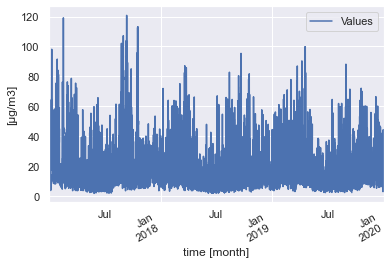

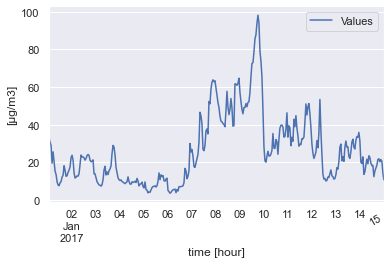

In [65]:
plot_cols = ['Values']
plot_features = NO2_stat[plot_cols]
plot_features.index = NO2_stat['Time']
_ = plot_features.plot(subplots=True)
plt.ylabel('[μg/m3]');
plt.xlabel('time [month]');

plot_features = NO2_stat[plot_cols][:336]
plot_features.index = NO2_stat['Time'][:336]
_ = plot_features.plot(subplots=True)
plt.ylabel('[μg/m3]');
plt.xlabel('time [hour]');

#### Dealing with outliers

In [57]:
NO2_stat['Values'].describe()

count    25811.000000
mean        16.949676
std         13.537545
min          1.653438
25%          8.130000
50%         12.970000
75%         21.094704
max        120.790000
Name: Values, dtype: float64

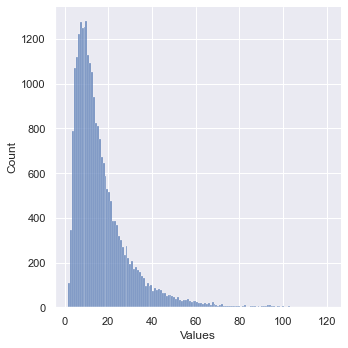

In [58]:
sns.displot(NO2_stat['Values'])

In [59]:
NO2_stat['Values'].describe()

count    25811.000000
mean        16.949676
std         13.537545
min          1.653438
25%          8.130000
50%         12.970000
75%         21.094704
max        120.790000
Name: Values, dtype: float64

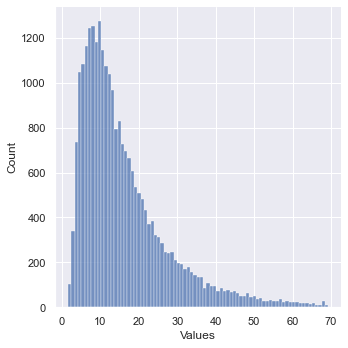

In [60]:
q = NO2_stat['Values'].quantile(0.99)
NO2_stat = NO2_stat[NO2_stat['Values']<q]
sns.displot(NO2_stat['Values'])

In [61]:
# Prophet requires columns ds (Date) and y (value)
NO2_stat = NO2_stat.rename(columns={'Time': 'ds', 'Values': 'y'})

In [16]:
#Decreasing changepoint_prior_scale will make the trend less flexible:
prophet = fbprophet.Prophet(changepoint_prior_scale=0.5,daily_seasonality=True)
prophet.fit(NO2_stat[:])

In [17]:
# Forecast for 1 month:
forecast = prophet.make_future_dataframe(periods=720, freq='H')
# Make predictions:
forecast = prophet.predict(forecast)
forecast['yhat'].min()

1.1535320244888148

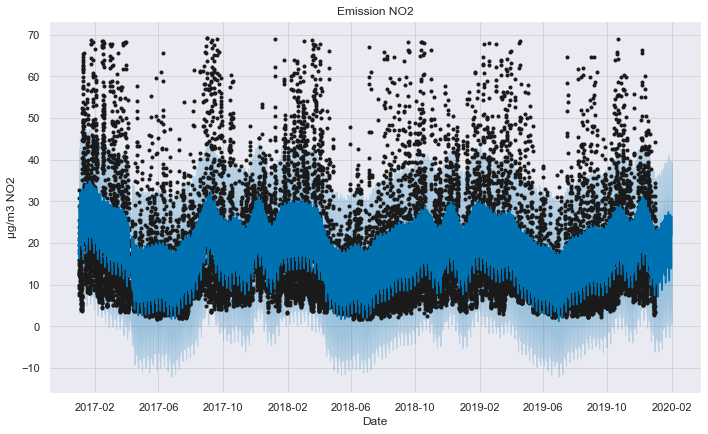

In [18]:
prophet.plot(forecast, xlabel = 'Date', ylabel = 'μg/m3 NO2')
plt.title('Emission NO2');

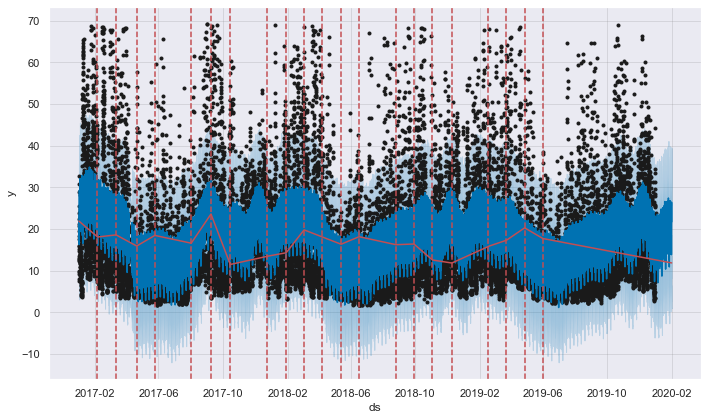

In [19]:

fig = prophet.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet, forecast)

In [20]:
%%time
forecast_2020_NO2_stat = forecast

Wall time: 0 ns


In [ ]:
# This may take a while.
# Sending NO2 emission forecast tables to SQL Server.
export_df_to_MSSQL(forecast_2020_NO2_stat,'DESKTOP-8RKU8L8',
                       'GIOŚ','forecast_2020_NO2_stat')

### 3 last days

In [5]:
conn = pyodbc.connect('Driver={SQL Server};'
                      'Server=DESKTOP-8RKU8L8;'
                      'Database=GIOŚ;'
                      'Trusted_Connection=yes;')
cursor = conn.cursor()

NO2_last_value = pd.read_sql_query("""exec LastValue 'Ot%', 'NO2' """,conn)
NO2_year = pd.read_sql_query("""select * from forecast_2020_NO2_stat""",conn)

In [6]:
#We could create model for any parameters, but here we consider a diffrent approach to the same problem.
#We are going to create forecast (model) based on last 3 days.
@performance
def create_forecast_2020(data, scale):
    data = data.rename(columns={'Time': 'ds', 'Values': 'y'})
#     data['y'] = np.log(data['y'])
    prophet = fbprophet.Prophet(changepoint_prior_scale=scale)
    prophet.fit(data)
    forecast = prophet.make_future_dataframe(periods=12, freq='H')
    forecast = prophet.predict(forecast)
    return forecast

NameError: name 'performance' is not defined

In [4]:
#Let's compere our forecasts with real world current value of NO2 parameter.

#Becasue GIOŚ provide value with 1 lag hour, we need to substract 1 from current time.
now = datetime.now() - timedelta(hours=1)
after = datetime.now() + timedelta(hours=3)
now_string = now.strftime("%Y-%m-%d %H:00:00")
after_string = after.strftime("%Y-%m-%d %H:00:00")

In [ ]:
NO2_dynamic_model = create_forecast_2020(NO2_last_value[['Time','Values']],0.5)

In [ ]:
NO2_last_value

### Summary
#### FB prophet models: yearly  vs. dayily 

In [48]:

#Let's compere our forecasts with real world current value of NO2 parameter.

#Becasue GIOŚ provide value with 1 lag hour according to current time, we need to substract 1 from current time.
now = datetime.now() - timedelta(hours=1)
now_string = now.strftime("%Y-%m-%d %H:00:00")
#Or we can put into model other date to make pred.
now_string = '2020-10-06 04:00:00'

summary_fb = pd.merge(NO2_dynamic_model.loc[NO2_dynamic_model['ds'] == now_string][['ds','yhat']], 
                  NO2_year.loc[NO2_year['ds'] == now_string][['ds','yhat']], 
                  on = 'ds', how='outer')


MzOtwBrzo_last = 'http://api.gios.gov.pl/pjp-api/rest/data/getData/16048'
MzOtwBrzo_last_res = requests.get(MzOtwBrzo_last).json()
act_current_val =  MzOtwBrzo_last_res['values'][-1]['value']

summary_fb['NO2 [μg/m3] actual current value'] = act_current_val
summary_fb.rename(columns={'ds':'Time',
                          'yhat_x':'NO2 [μg/m3] daily',
                          'yhat_y':'NO2 [μg/m3] yearly'}, inplace=True)

summary_fb
#Check this out too:
#http://powietrze.gios.gov.pl/pjp/current/station_details/chart/485

,Time,NO2 [μg/m3] daily,NO2 [μg/m3] yearly,NO2 [μg/m3] actual current value
0,2020-10-06 04:00:00,6.602864,14.16072,8.91


# Summary

In [ ]:
#Let's compere our forecasts with real world current value of NO2 parameter.

#Becasue GIOŚ provide value with 1 lag hour, we need to substract 1 from current time.
now = datetime.now() - timedelta(hours=1)
after = datetime.now() + timedelta(hours=3)
now_string = now.strftime("%Y-%m-%d %H:00:00")
after_string = after.strftime("%Y-%m-%d %H:00:00")

In [ ]:
#Forecast - model :
start_index = now_string
end_index = after_string
forecast = results_Val2_ar_3.predict(start=start_index, end=end_index)

In [ ]:
MzOtwBrzo_last = 'http://api.gios.gov.pl/pjp-api/rest/data/getData/16048'
MzOtwBrzo_last_res = requests.get(MzOtwBrzo_last).json()
print('Current value: ', MzOtwBrzo_last_res['values'][-1]['value'])
print('Prediction: ', round(forecast[0],2))